[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1aONS2w8PyE4Y4T5vzBTMLu2u36_O8TE2#scrollTo=1wzHARKol9Af)

[Caso Practico](https://drive.google.com/file/d/1uPzOMackxxcOpVlArik54AJV7VBz0y8D/view?usp=sharing)


*La empresa necesita saber a quién sería conveniente aceptarle el préstamo hipotecario, para así poder rentabilizar su capital y no tener problemas de morosidad.*

---

## **Configuración Inicial**

**Conexion Drive**

In [1]:
# Si necesitas ejecutar el notebook con un archivo desde tu drive personal
# from google.colab import drive
# drive.mount('/gdrive')

#Repositorios
# path = '/gdrive/MyDrive/BQ - Data Science/BQ - Repositorios/Repositorio_Portafolio/'
# filename = "AdquisicionCreditoHipotecario.csv"
# fullpath = os.path.join(path, filename)

**Librerias**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Para los graficos tengan las mismas dimensiones
%matplotlib inline
plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = (7, 4)

pd.options.display.max_columns = None
sns.set_style('whitegrid')
color = sns.color_palette()

**Rutas**

In [4]:
fullpath = 'https://raw.githubusercontent.com/bryanOsmar07/Data_Repository/main/AdquisicionCreditoHipotecario.csv'

# Anexos

In [5]:
import numpy as np
import pandas as pd
import graphviz, IPython
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.ticker import FuncFormatter
from sklearn.tree import export_graphviz

def draw_tree(tree, df):
    s = export_graphviz(tree, out_file=None, feature_names=df.columns, filled=True)
    return graphviz.Source(s)

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

# Based on https://github.com/chrispaulca/waterfall.git
def waterfallplot(sample, data, Title="", x_lab="", y_lab="",
		 formatting="{:,.1f}", green_color='#29EA38', red_color='#FB3C62', blue_color='#24CAFF',
		 sorted_value=False, threshold=None, other_label='other', net_label='net',
		 rotation_value=0, size=None):
	'''
	Given two sequences ordered appropriately, generate a standard waterfall chart.
	Optionally modify the title, axis labels, number formatting, bar colors,
	increment sorting, and thresholding. Thresholding groups lower magnitude changes
	into a combined group to display as a single entity on the chart.
	'''

	#convert data and index to np.array
	index = np.array([f'{c}\n({sample[c].iloc[0]})' for c in sample])
	data = np.array(data)

	# wip
	#sorted by absolute value
	if sorted_value:
		abs_data = abs(data)
		data_order = np.argsort(abs_data)[::-1]
		data = data[data_order]
		index = index[data_order]

	#group contributors less than the threshold into 'other'
	if threshold:

		abs_data = abs(data)
		threshold_v = abs_data.max()*threshold

		if threshold_v > abs_data.min():
			index = np.append(index[abs_data>=threshold_v],other_label)
			data = np.append(data[abs_data>=threshold_v],sum(data[abs_data<threshold_v]))

	changes = {'amount' : data}

	#define format formatter
	def money(x, pos):
		'The two args are the value and tick position'
		return formatting.format(x)
	formatter = FuncFormatter(money)

	fig, ax = plt.subplots(figsize=size)
	ax.yaxis.set_major_formatter(formatter)

	#Store data and create a blank series to use for the waterfall
	trans = pd.DataFrame(data=changes,index=index)
	blank = trans.amount.cumsum().shift(1).fillna(0)

	trans['positive'] = trans['amount'] > 0

	#Get the net total number for the final element in the waterfall
	total = trans.sum().amount
	trans.loc[net_label]= total
	blank.loc[net_label] = total

	#The steps graphically show the levels as well as used for label placement
	step = blank.reset_index(drop=True).repeat(3).shift(-1)
	step[1::3] = np.nan

	#When plotting the last element, we want to show the full bar,
	#Set the blank to 0
	blank.loc[net_label] = 0

	#define bar colors for net bar
	trans.loc[trans['positive'] > 1, 'positive'] = 99
	trans.loc[trans['positive'] < 0, 'positive'] = 99
	trans.loc[(trans['positive'] > 0) & (trans['positive'] < 1), 'positive'] = 99

	trans['color'] = trans['positive']

	trans.loc[trans['positive'] == 1, 'color'] = green_color
	trans.loc[trans['positive'] == 0, 'color'] = red_color
	trans.loc[trans['positive'] == 99, 'color'] = blue_color

	my_colors = list(trans.color)

	#Plot and label
	my_plot = plt.bar(range(0,len(trans.index)), blank, width=0.5, color='white')
	plt.bar(range(0,len(trans.index)), trans.amount, width=0.6,
			 bottom=blank, color=my_colors)


	# connecting lines - figure out later
	#my_plot = lines.Line2D(step.index, step.values, color = "gray")
	#my_plot = lines.Line2D((3,3), (4,4))

	#axis labels
	plt.xlabel("\n" + x_lab)
	plt.ylabel(y_lab + "\n")

	#Get the y-axis position for the labels
	y_height = trans.amount.cumsum().shift(1).fillna(0)

	temp = list(trans.amount)

	# create dynamic chart range
	for i in range(len(temp)):
		if (i > 0) & (i < (len(temp) - 1)):
			temp[i] = temp[i] + temp[i-1]

	trans['temp'] = temp

	plot_max = trans['temp'].max()
	plot_min = trans['temp'].min()

	#Make sure the plot doesn't accidentally focus only on the changes in the data
	if all(i >= 0 for i in temp):
		plot_min = 0
	if all(i < 0 for i in temp):
		plot_max = 0

	if abs(plot_max) >= abs(plot_min):
		maxmax = abs(plot_max)
	else:
		maxmax = abs(plot_min)

	pos_offset = maxmax / 40

	plot_offset = maxmax / 15 ## needs to me cumulative sum dynamic

	#Start label loop
	loop = 0
	for index, row in trans.iterrows():
		# For the last item in the list, we don't want to double count
		if row['amount'] == total:
			y = y_height[loop]
		else:
			y = y_height[loop] + row['amount']
		# Determine if we want a neg or pos offset
		if row['amount'] > 0:
			y += (pos_offset*2)
			plt.annotate(formatting.format(row['amount']),(loop,y),ha="center", color = 'g', fontsize=9)
		else:
			y -= (pos_offset*4)
			plt.annotate(formatting.format(row['amount']),(loop,y),ha="center", color = 'r', fontsize=9)
		loop+=1

	#Scale up the y axis so there is room for the labels
	plt.ylim(plot_min-round(3.6*plot_offset, 7),plot_max+round(3.6*plot_offset, 7))

	#Rotate the labels
	plt.xticks(range(0,len(trans)), trans.index, rotation=rotation_value)

	#add zero line and title
	plt.axhline(0, color='black', linewidth = 0.6, linestyle="dashed")
	plt.title(Title)
	plt.tight_layout()

	return plt

# Lectura de datos

In [6]:
df = pd.read_csv(fullpath)

In [7]:
print(df.shape)
df.head(3)

(614, 13)


,Loan ID,Gender,Married,Dependents,Education,Self Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


# Data Wrangling

In [8]:
df.columns

Index(['Loan ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [9]:
# Por buenas practicas, debemos renombrar el nombre de las variables

In [10]:
columns_name = ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']

In [11]:
df.columns = columns_name
df.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


In [12]:
# Validamos si los tipos de variables son los adecuados

In [13]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

El ingreso deberia ser una variable numerica continua

In [14]:
df['ApplicantIncome'] = df['ApplicantIncome'].astype('float64')

In [15]:
# Diferenciamos el tipo de variables
columnsNumeric = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History']
columnsString = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']

El tipo de Credit_History debe ser objet para clasificarlo como 1 o 0.

In [16]:
df['Credit_History'] = df['Credit_History'].astype('O')

Eliminamos el Loan_ID porque no es importante para nuestro modelo

In [17]:
df.drop('Loan_ID', axis=1, inplace=True)

Revisamos duplicados

In [18]:
df.duplicated().any()

False

In [19]:
# Validando registros únicos
print(df.shape)
print(df[columnsString].nunique())

(614, 12)
Gender           2
Married          2
Dependents       4
Education        2
Self_Employed    2
Property_Area    3
Loan_Status      2
dtype: int64


# **I. Analisis Exploratorio**

In [20]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Gender,601,2,Male,489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Married,611,2,Yes,398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,599,4,0,345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,614,2,Graduate,480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Self_Employed,582,2,No,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ApplicantIncome,614.0,NaN,NaN,NaN,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.0,81000.0
CoapplicantIncome,614.0,NaN,NaN,NaN,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,NaN,NaN,NaN,146.412162,85.587325,9.0,100.0,128.0,168.0,700.0
Loan_Amount_Term,600.0,NaN,NaN,NaN,342.0,65.12041,12.0,360.0,360.0,360.0,480.0
Credit_History,564.0,2.0,1.0,475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Revision Objetivo

Porcentaje de Creditos Aprobados : 0.69
Porcentaje de Creditos Rechazados : 0.31


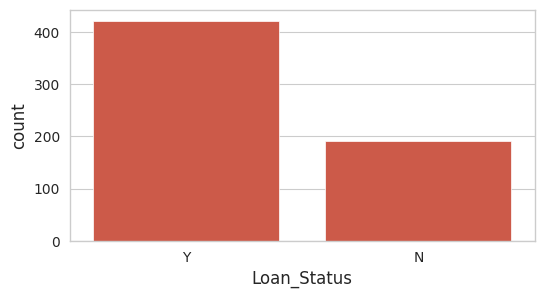

In [21]:
plt.figure(figsize=(6,3))
sns.countplot(x='Loan_Status', data=df);

print('Porcentaje de Creditos Aprobados : %.2f' % (df['Loan_Status'].value_counts()[0] / len(df)))
print('Porcentaje de Creditos Rechazados : %.2f' % (df['Loan_Status'].value_counts()[1] / len(df)))

In [22]:
# Revisamos el tiempo de los prestamos
df.groupby('Loan_Amount_Term').size()

Loan_Amount_Term
12.0       1
36.0       2
60.0       2
84.0       4
120.0      3
180.0     44
240.0      4
300.0     13
360.0    512
480.0     15
dtype: int64

Segun la base, hay prestamos que van desde los 12 meses (1 año) hasta los 480 meses (40 años). Los prestamos hipotecarios menores a 10 años no tienen sentido.

Segun el ejercicio, nos indica que no pueden haber prestamos con menos de 10 años

In [23]:
# Elegimos solo las caracteristicas deseadas
df_alt = df[df['Loan_Amount_Term']>=120]
print(df_alt.shape)
df_alt.head(3)

(591, 12)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849.0,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y


In [24]:
# Revisamos el tiempo de los prestamos
df_alt.groupby('Loan_Amount_Term').size()

Loan_Amount_Term
120.0      3
180.0     44
240.0      4
300.0     13
360.0    512
480.0     15
dtype: int64

## Analisis Univariado

### Categoricas

Gender
Female    112
Male      489
dtype: int64


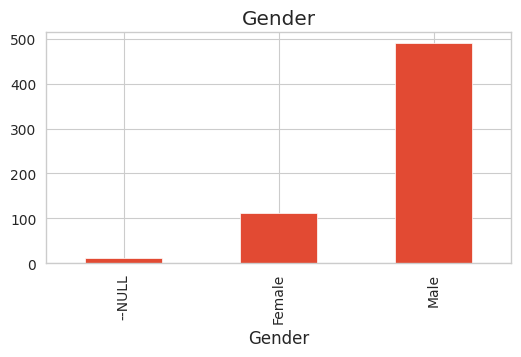

Married
No     213
Yes    398
dtype: int64


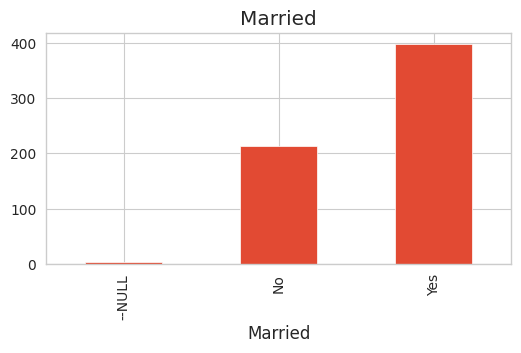

Dependents
0     345
1     102
2     101
3+     51
dtype: int64


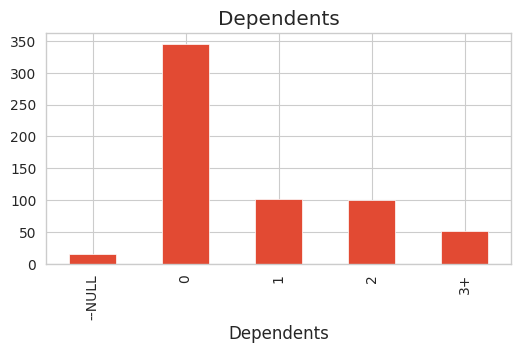

Education
Graduate        480
Not Graduate    134
dtype: int64


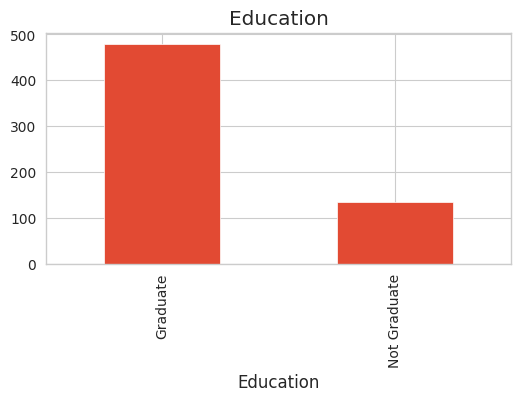

Self_Employed
No     500
Yes     82
dtype: int64


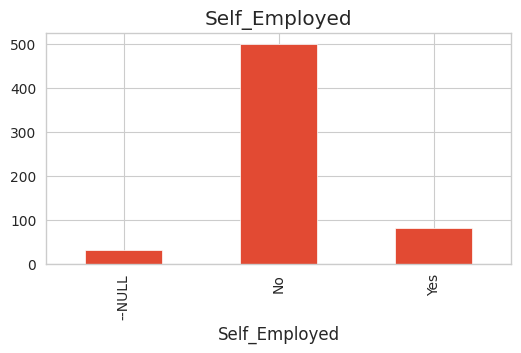

Property_Area
Rural        179
Semiurban    233
Urban        202
dtype: int64


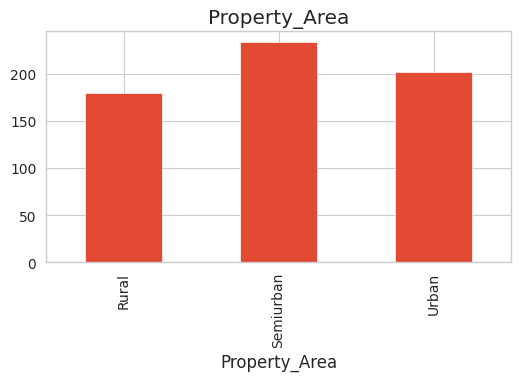

Loan_Status
N    192
Y    422
dtype: int64


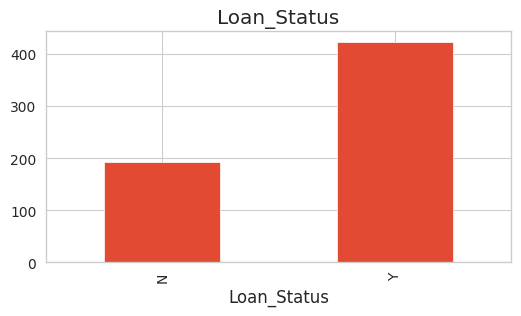

In [25]:
for x in columnsString:
  plt.figure(figsize=(6,3))
  print(df.groupby(x).size())
  plt.title(x)
  df.fillna("--NULL").groupby(x)[x].count().plot(kind = "bar")
  plt.show()

### Numericas

In [26]:
df[columnsNumeric].describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0


* Vemos que las variables LoanAmount y Credit_History tienen valores perdidos
* Vemos que la media y la mediana difieren en algunos casos, esto puede ser por la presencia de outliers
* Vemos que en la mayoria de casos, la desviacion es grande, por lo cual podemos decir que los datos no son homogeneos

In [27]:
df[columnsNumeric].dtypes

ApplicantIncome      float64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History        object
dtype: object

* podemos ver que cuando obtuvimos la mediana baja en CoapplicantInocme obtuvimos Loan_Status = N

**CoapplicantInocme: característica importante**

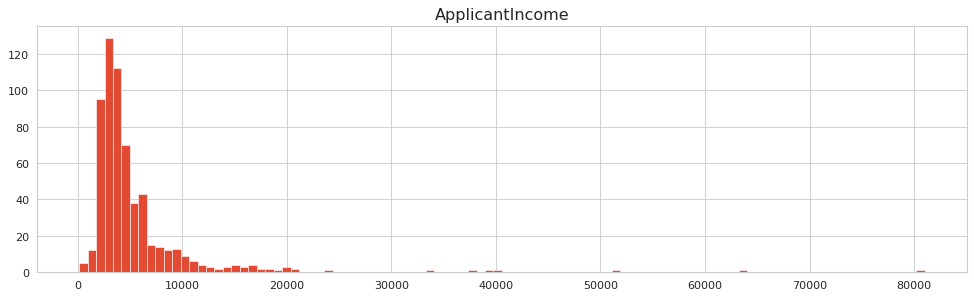

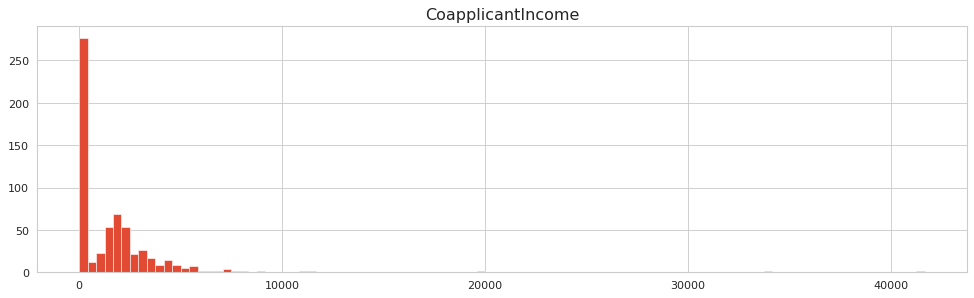

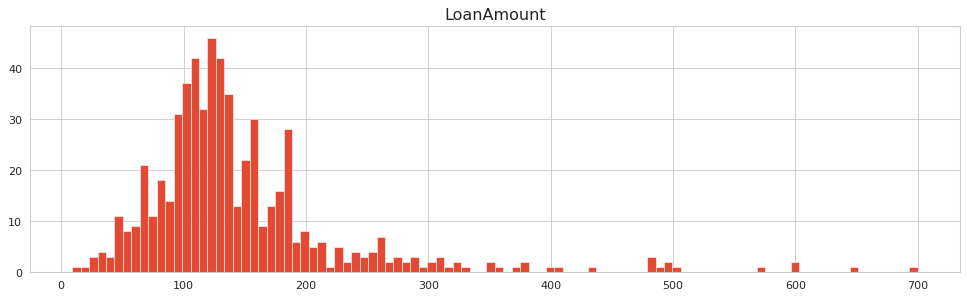

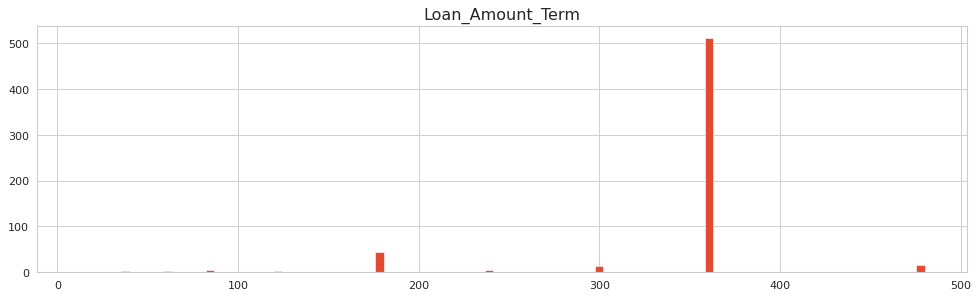

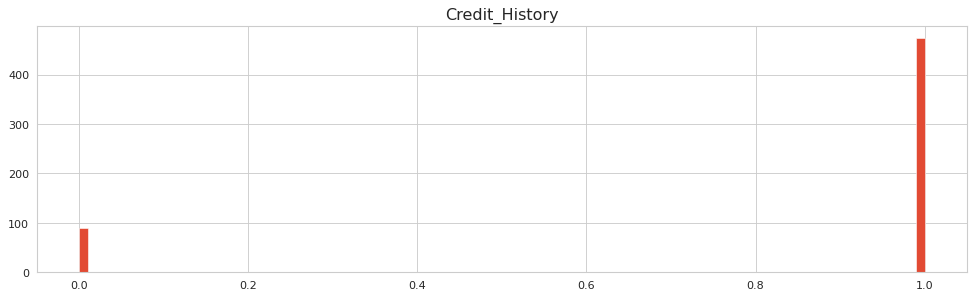

In [28]:
for x in columnsNumeric:
  plt.figure(figsize=(15,4), dpi=80)
  plt.title(df[x].name)
  plt.hist(df[x],bins=100)
  plt.show()

* Tenemos variables asimetricas positivas que posiblemente requieran
transformaciones o alguna recategorizacion.
* Vemos que la distribucion es asimetrica positiva (los valores atipicos estan a la derecha)

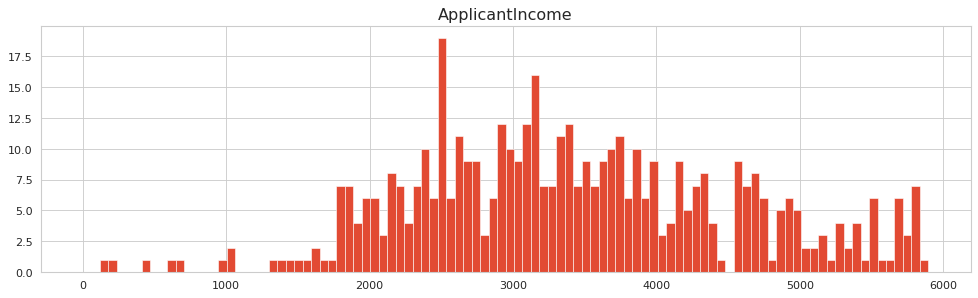

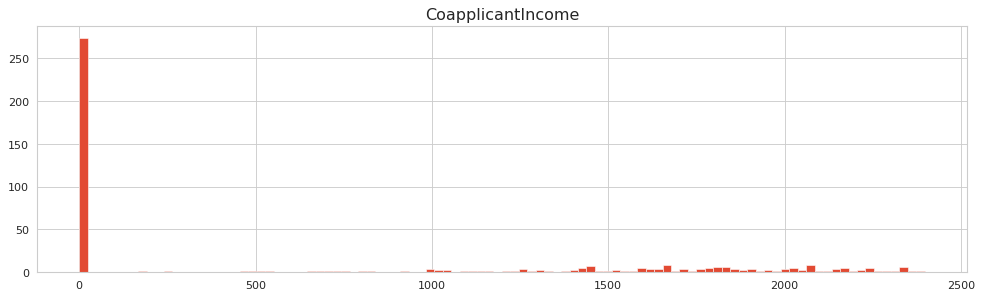

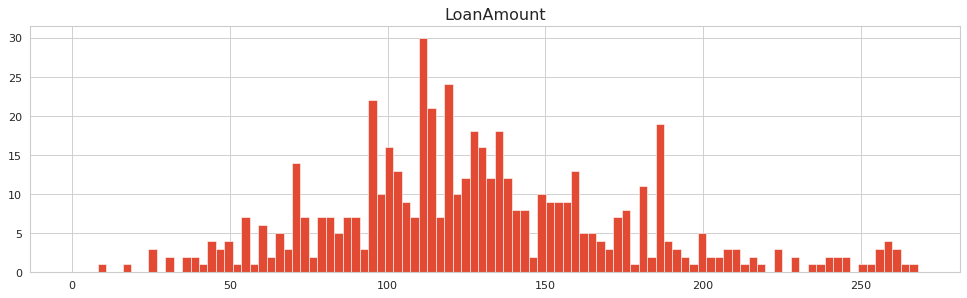

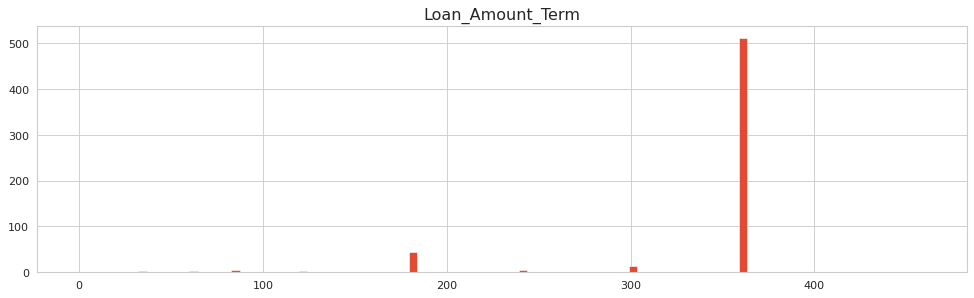

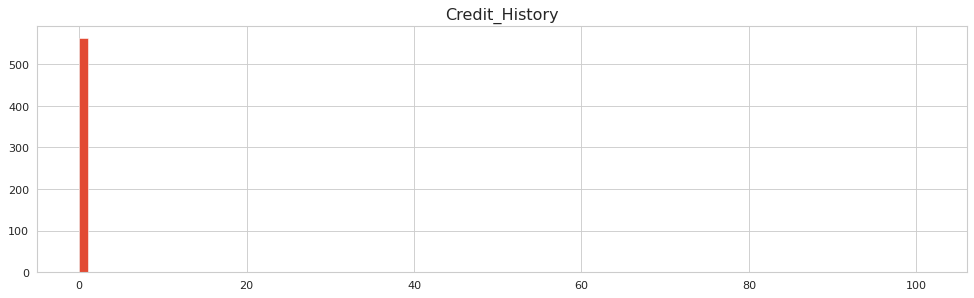

In [29]:
# No consideramos las colas (outliers) para ver mejor la distribucion
for x in columnsNumeric:
  plt.figure(figsize=(15,4), dpi=80)
  Q03= int(df[x].quantile(0.75))+100
  plt.title(df[x].name)
  plt.hist(df[x],bins=100,range=(0,Q03))
  plt.show()

Al retirar los outlier, la distribucion es mas simetrica, es decir la varianza se reduce (se normaliza)
* Los ingresos se encuentran alrededor del promedio
* Normalizando los valores, mejoro la visualizacion

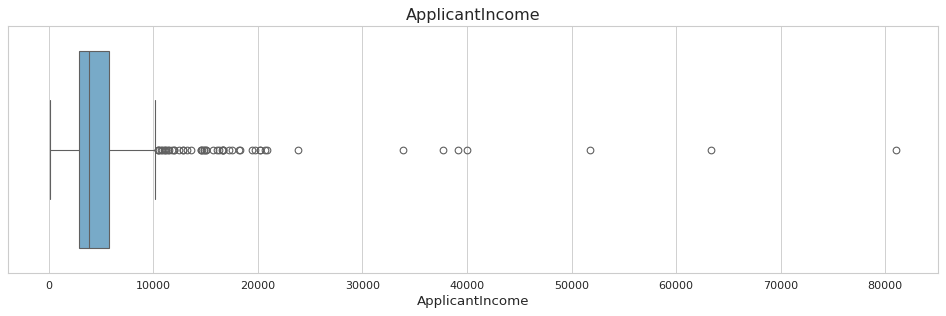

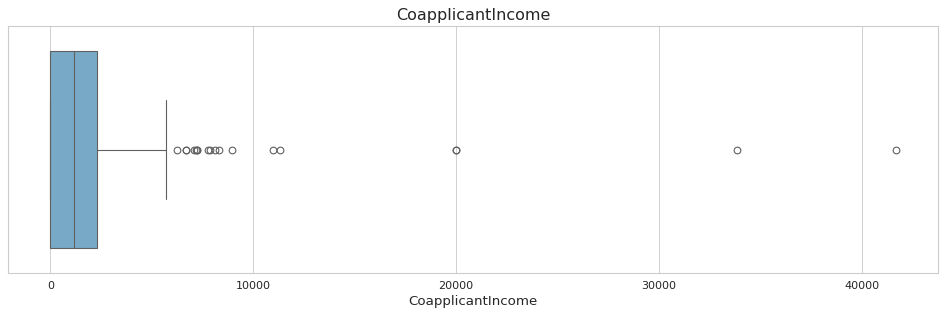

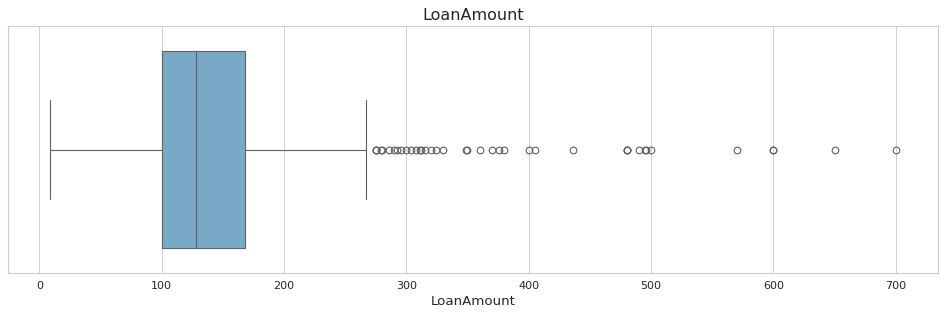

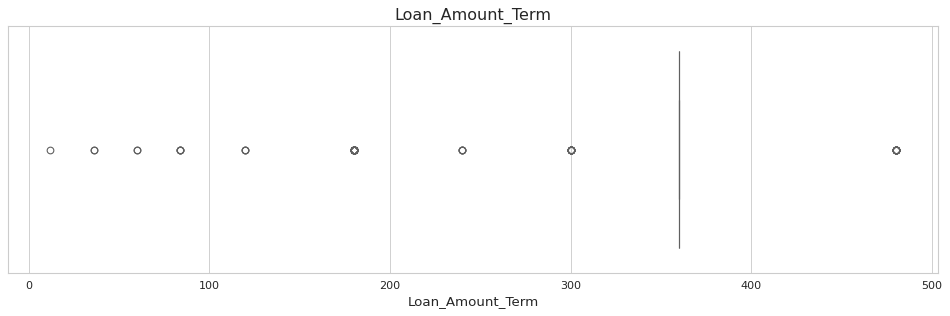

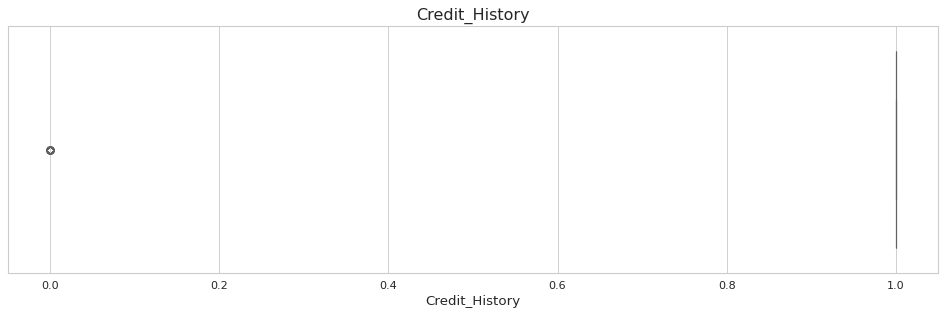

In [30]:
# Grafico de Cajas para revision de atipicos
for x in columnsNumeric:
  plt.figure(figsize=(15,4), dpi=80)
  plt.title(df[x].name)
  sns.boxplot(x=df[x], palette="Blues")
  plt.show()

* Vemos que en el ingreso (ApplicantIncome) hay datos atipicos, pues existen personas que llegan a ganar 80K

## Anlisis Bivariado

### Categoricas

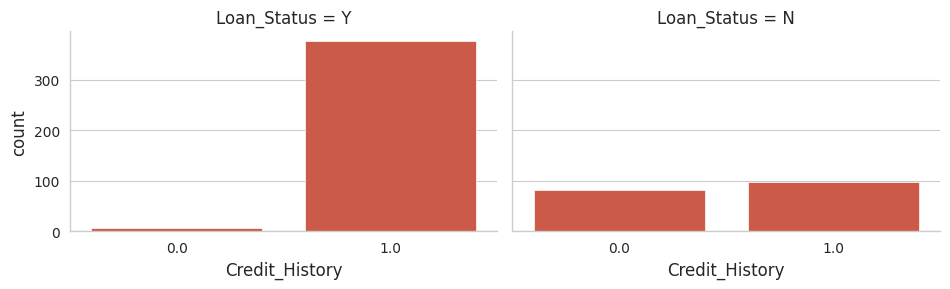

In [31]:
# Credit_History

grid = sns.FacetGrid(df,col='Loan_Status', aspect=1.6)
grid.map(sns.countplot, 'Credit_History');

* No otorgamos un préstamo a la mayoría de las personas que obtuvieron Historial crediticio = 0
* pero otorgamos un préstamo a la mayoría de las personas que obtuvieron historial crediticio = 1
* entonces podemos decir que si tiene Historial de crédito = 1, tendrá más posibilidades de obtener un préstamo

**característica importante**

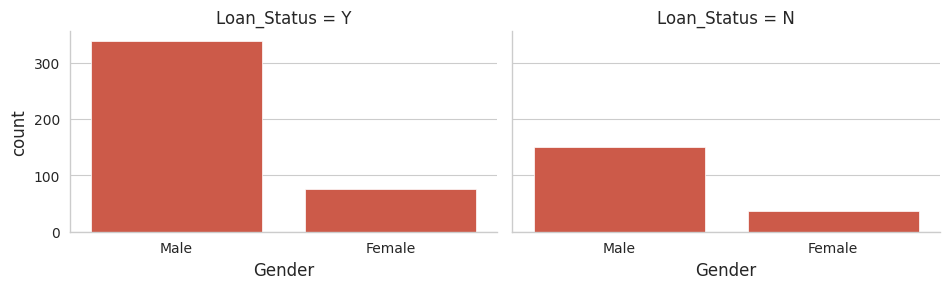

In [32]:
# Gender

grid = sns.FacetGrid(df,col='Loan_Status', aspect=1.6)
grid.map(sns.countplot, 'Gender');

* la mayoría de los hombres obtuvieron préstamos y la mayoría de las mujeres también obtuvieron uno (sin patrón)

**No parece ser una caracteristica importante**

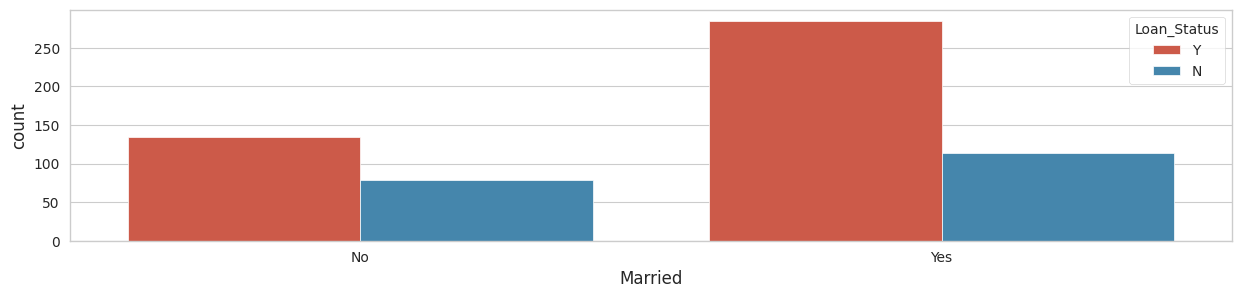

In [33]:
# Married
plt.figure(figsize=(15,3))
sns.countplot(x='Married', hue='Loan_Status', data=df);

* la mayoría de las personas que se casan obtuvieron un préstamo
* si estás casado, entonces tienes más posibilidades de obtener un préstamo

**característica importante**

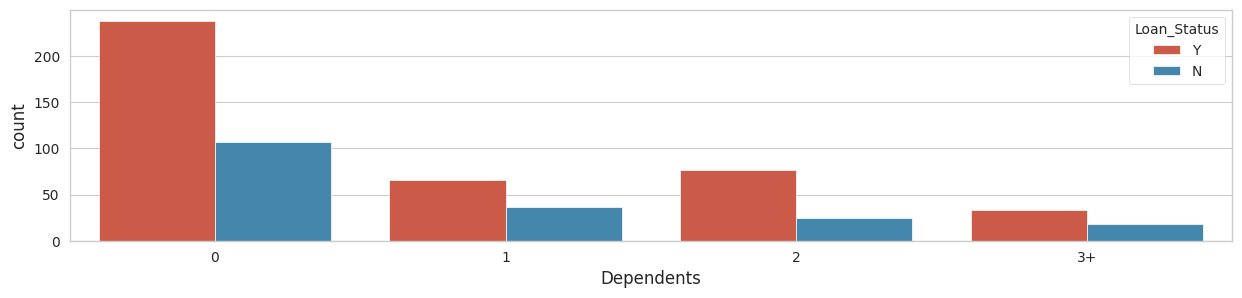

In [34]:
# Dependents

plt.figure(figsize=(15,3))
sns.countplot(x='Dependents', hue='Loan_Status', data=df);

* Si el numero de Dependientes = 0, tenemos mayor probabilidad de obtener un préstamo ((muy alta probabilidad))

**característica importante**

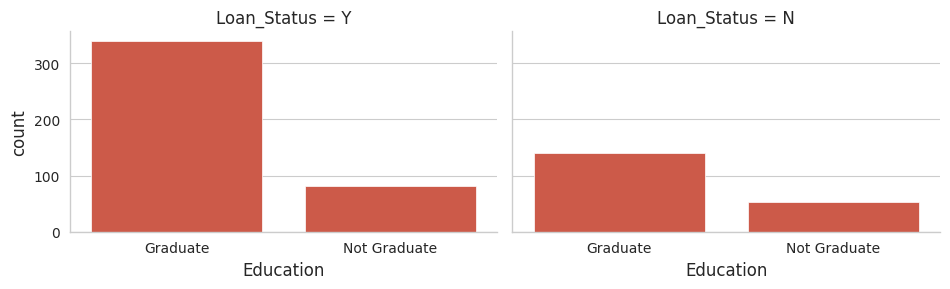

In [35]:
# Education

grid = sns.FacetGrid(df,col='Loan_Status', aspect=1.6)
grid.map(sns.countplot, 'Education');

* Si está graduado o no, tendrá casi las mismas posibilidades de obtener un préstamo (sin patrón)
* Aquí puede ver que la mayoría de las personas se graduaron y la mayoría obtuvo un préstamo.
* por otro lado, la mayoría de las personas que no se graduaron también obtuvieron un préstamo, pero con un porcentaje menor de personas que se graduaron

**No parece ser una caracteristica importante**

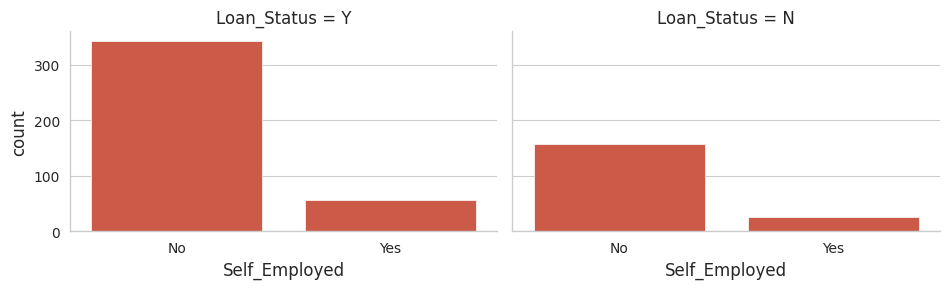

In [36]:
# Self_Employed

grid = sns.FacetGrid(df,col='Loan_Status', aspect=1.6)
grid.map(sns.countplot, 'Self_Employed');

* No existe un patrón (igual que Educación)

**No parece ser una caracteristica importante**

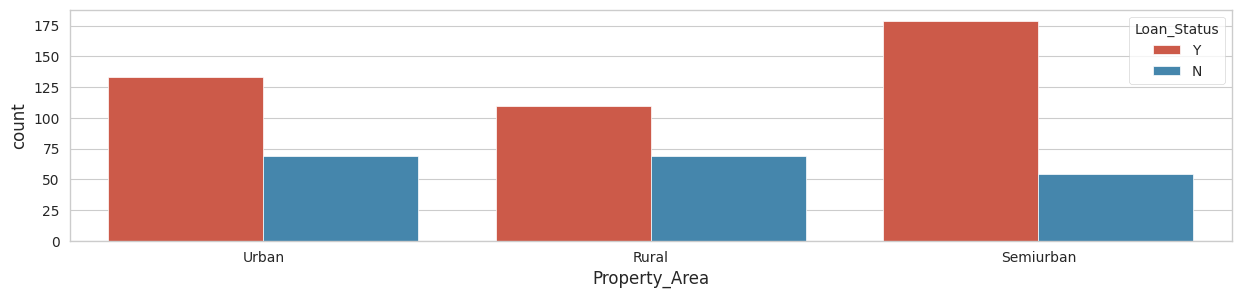

In [37]:
# Property_Area

plt.figure(figsize=(15,3))
sns.countplot(x='Property_Area', hue='Loan_Status', data=df);

* Podemos decir que Semiurban Property_Area tiene más del 50% de posibilidades de obtener un préstamo

**característica importante**

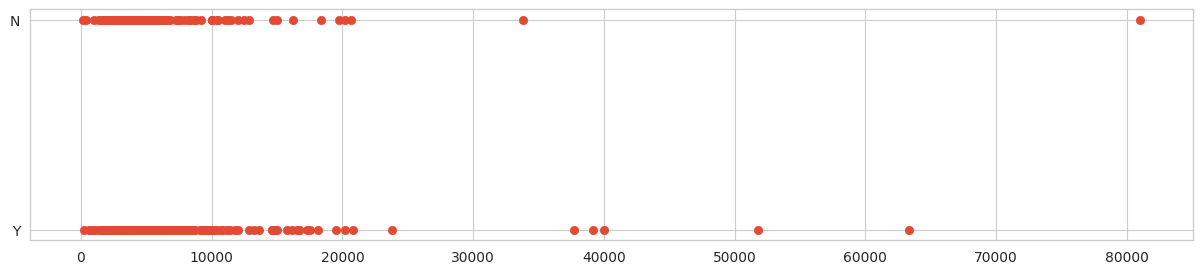

In [38]:
# ApplicantIncome

plt.figure(figsize=(15,3))
plt.scatter(df['ApplicantIncome'], df['Loan_Status']);

* No existe un patrón

**No parece ser una caracteristica importante**

### Numericas

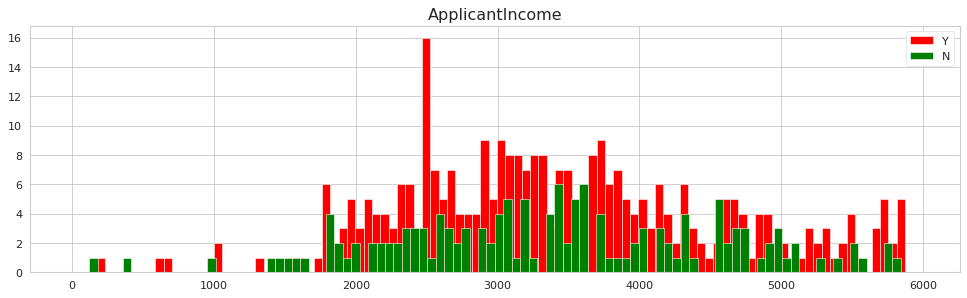

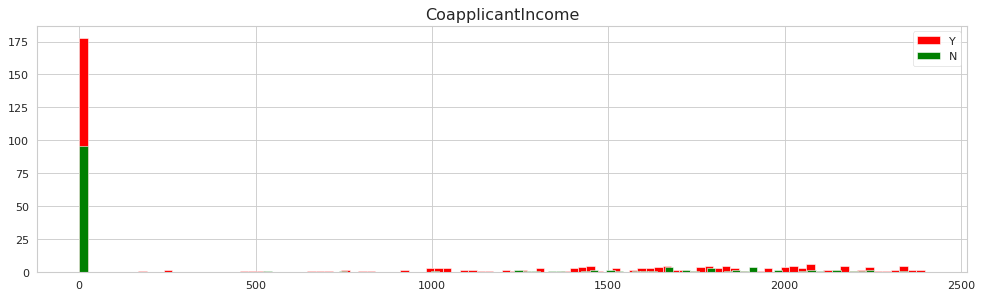

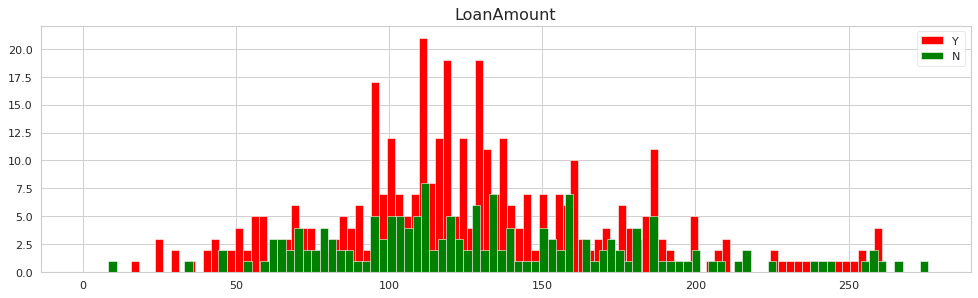

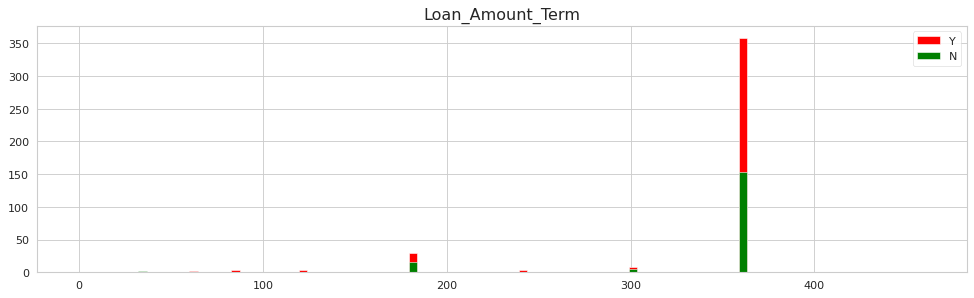

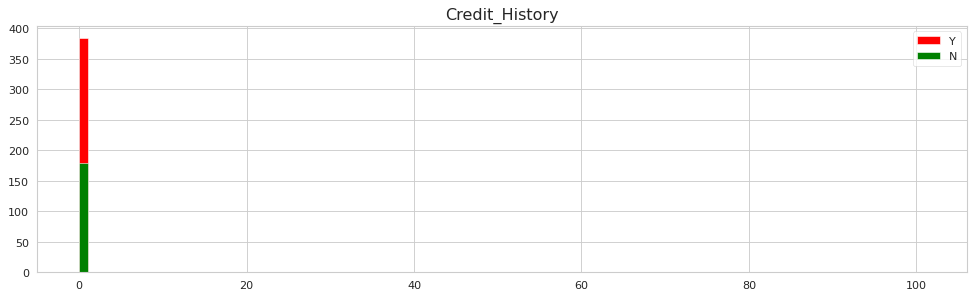

In [39]:
# Analizando variables numericas con respecto al target
for x in columnsNumeric:
  plt.figure(figsize=(15,4), dpi=80)
  x1 = df.loc[df['Loan_Status']=='Y',x]  #Serie
  x2 = df.loc[df['Loan_Status']=='N',x]  #serie

  Q03x1 = int(pd.DataFrame(x1)[x].quantile(0.75))+100  # Q3 de la serie
  Q03x2 = int(pd.DataFrame(x2)[x].quantile(0.75))+100  # Q3 de la serie

  #se muestran las densidades
  plt.title(df[x].name)
  plt.hist(x1,bins=100,color='r',range=(0,Q03x1),label='Y')
  plt.hist(x2,bins=100,color='g',range=(0,Q03x2),label='N')
  plt.legend()
  plt.show()

* Se le suele dar prestamos cuando el monto (loant_amount) esta entre 80 y 200
* Las personas con mayores ingresos generalmente se les da el prestamo
* Personas con deuda en prestamo bajas, son propensas dar el hipotecario

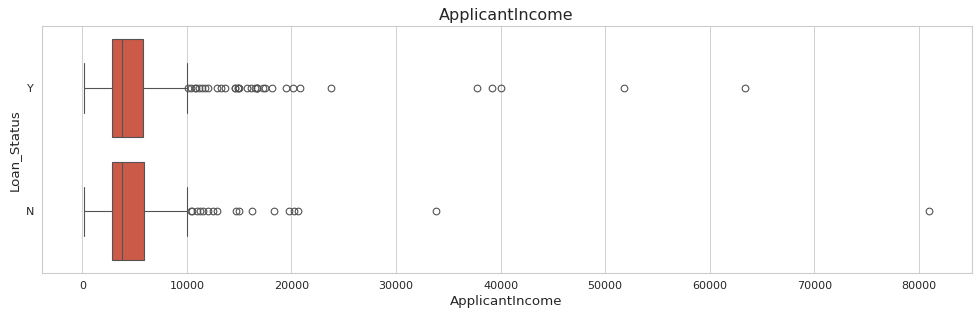

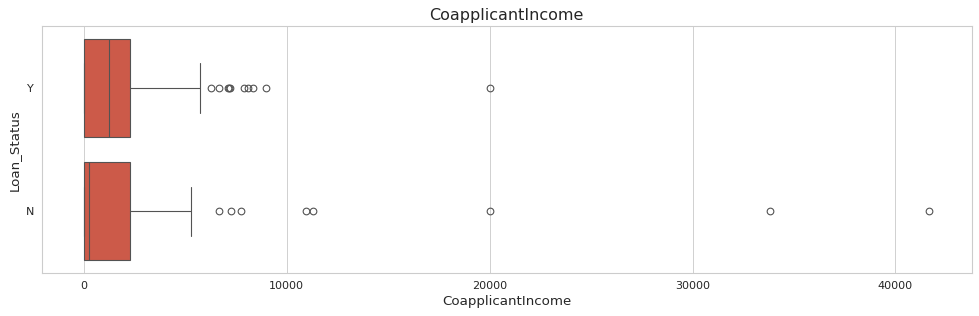

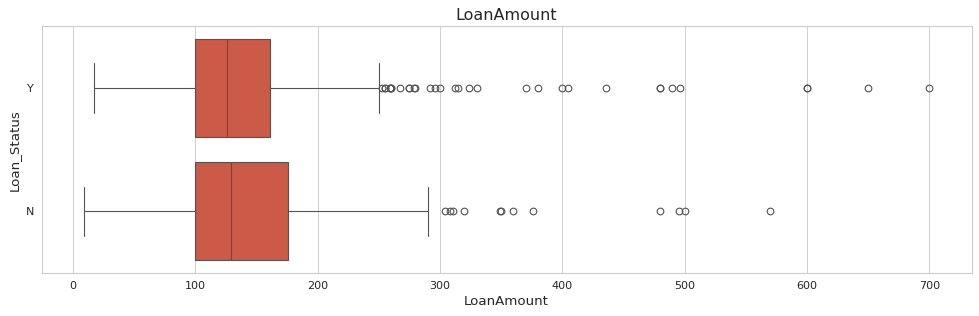

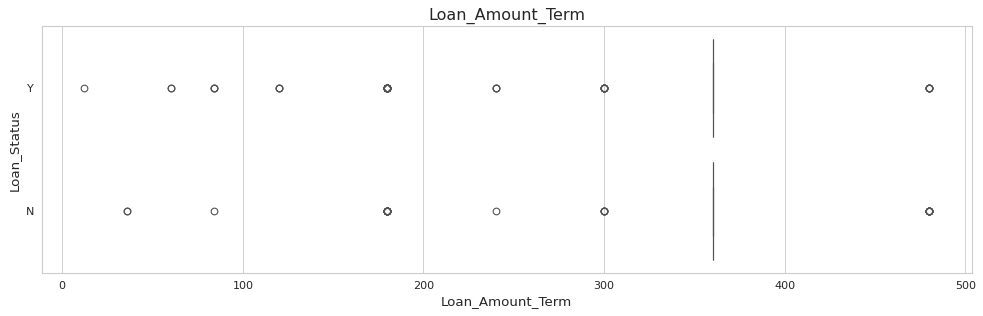

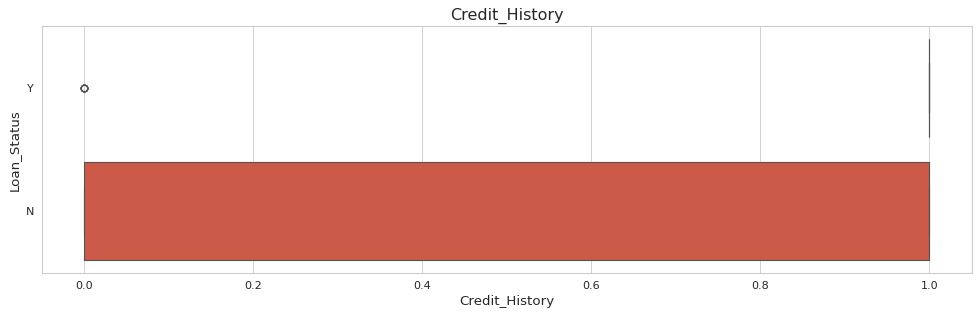

In [40]:
# Grafico de cajas respecto al target
for x in columnsNumeric:
  plt.figure(figsize=(15,4), dpi=80)
  plt.title(df[x].name)
  sns.boxplot(x=df[x],y=df['Loan_Status'])
  plt.show()

* El ingreso dependiente (ApplicantIncome) no es una buena variable predictora, pues ambos graficos son asimetricas positivas, la mediana es casi similar, tienen casi la misma cantidad de outliers
* El ingreso independiente (CoapplicantIncome) si podria ser buena variable predictora, pues la mediana esta mas arriba a las personas que se les da el prestamo.
* Monto del prestamo (loan_amount), a los que si se les dio el prestamo tiene montos pequeños y son similares, mientras que la gente que no se le dio el prestamo tiene tambien montos pequeños pero es mas diversificado (heterogeneo)

## Analisis Multivariado

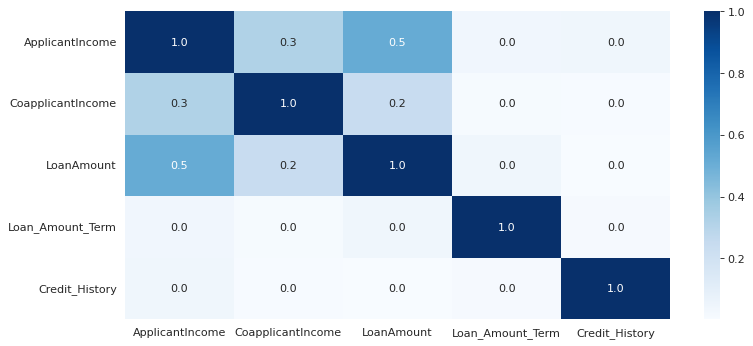

In [41]:
# Analizamos la correlacion de las variables
# Spearman: Para variables numericas. No asume normalidad
plt.figure(figsize=(11,5), dpi=80)
sns.heatmap(abs(df[columnsNumeric].corr(method='spearman')),annot=True,fmt='.1f',cmap='Blues')
plt.show()

* Hay cierta relacion entre el ingreso dependiente y el ingreso independiente, pero no hay problemas de colinealidad o multicolinealidad
* Existe cierta asociacion entre LoanAmount y ApplicantIncome (0.5)

## Tratamiento de Nulos

In [42]:
df.isnull().sum().sort_values(ascending=False)

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

In [43]:
df.isnull().sum()/df.shape[0]*100

Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

Se tienen valores perdidos, pero no es recomendable eliminarlos ya que no pasa del 10%

### Imputacion Simple

In [44]:
# Separaremos las columnas numéricas de las categóricas (en 2 dataframes)
cat_data = []
num_data = []

for i,c in enumerate(df.dtypes):
    if c == object:
        cat_data.append(df.iloc[:, i])
    else :
        num_data.append(df.iloc[:, i])

In [45]:
cat_data = pd.DataFrame(cat_data).transpose()
num_data = pd.DataFrame(num_data).transpose()

In [46]:
cat_data.head(2)

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,1.0,Rural,N


In [47]:
num_data.head(2)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
0,5849.0,0.0,NaN,360.0
1,4583.0,1508.0,128.0,360.0


In [48]:
# Completar por most frecuent

cat_data = cat_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
cat_data.isnull().sum().any()

False

In [49]:
# Completar con el valor anterior

num_data.fillna(method='bfill', inplace=True)
num_data.isnull().sum().any()

False

#### Recodificacion Data

In [50]:
from sklearn.preprocessing import LabelEncoder

In [51]:
le = LabelEncoder()

# transformacion del target

target_values = {'Y': 0 , 'N' : 1}

target = cat_data['Loan_Status']
cat_data.drop('Loan_Status', axis=1, inplace=True)

target = target.map(target_values)

# transformacion del resto de columnas categoricas

for i in cat_data:
    cat_data[i] = le.fit_transform(cat_data[i])

In [52]:
cat_data.head(2)

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area
0,1,0,0,0,0,1,2
1,1,1,1,0,0,1,0


In [53]:
df2 = pd.concat([cat_data, num_data, target], axis=1)
print(df2.shape)
df2.head(3)

(614, 12)


,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status
0,1,0,0,0,0,1,2,5849.0,0.0,128.0,360.0,0
1,1,1,1,0,0,1,0,4583.0,1508.0,128.0,360.0,1
2,1,1,0,0,1,1,2,3000.0,0.0,66.0,360.0,0


### Imputacion Univariada

In [54]:
from sklearn.impute import SimpleImputer

In [55]:
#Imputacion Univariada Numerica
imp_univ_num = SimpleImputer(missing_values=np.nan,strategy='median')
#Iputacion univariada categorica
imp_univ_cat = SimpleImputer(missing_values=np.nan,strategy='most_frequent')

In [56]:
# Generamos los subset de variables a imputar
data_imp_cat = df[columnsString]
data_imp_num = df[columnsNumeric]

In [57]:
# Realizamos la imputacion univariada numerica
imp_univ_num.fit(data_imp_num)
imputed_data_univ_num = pd.DataFrame(data=imp_univ_num.transform(data_imp_num),
                                     columns=data_imp_num.columns,dtype='float')

# Realizamos la imputacion univariada categorica
imp_univ_cat.fit(data_imp_cat)
imputed_data_univ_cat = pd.DataFrame(data=imp_univ_cat.transform(data_imp_cat),
                                     columns=data_imp_cat.columns,dtype='object')

In [58]:
# validamos la imputacion numerica
imputed_data_univ_num.isnull().sum()

ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
dtype: int64

In [59]:
# validamos la imputacion categorica
imputed_data_univ_cat.isnull().sum()

Gender           0
Married          0
Dependents       0
Education        0
Self_Employed    0
Property_Area    0
Loan_Status      0
dtype: int64

In [60]:
# Consolidamos el dataset
df3 = pd.concat([imputed_data_univ_num,imputed_data_univ_cat],axis=1)

#### Recodificacion Data

In [61]:
from sklearn.preprocessing import LabelEncoder

In [62]:
for c in columnsString:
  print(str(c))
  le = LabelEncoder()
  le.fit(df3[str(c)])
  df3[str(c)] = le.transform(df3[str(c)])

Gender
Married
Dependents
Education
Self_Employed
Property_Area
Loan_Status


In [63]:
print(df3.shape)
df3.head(3)

(614, 12)


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,5849.0,0.0,128.0,360.0,1.0,1,0,0,0,0,2,1
1,4583.0,1508.0,128.0,360.0,1.0,1,1,1,0,0,0,0
2,3000.0,0.0,66.0,360.0,1.0,1,1,0,0,1,2,1


In [64]:
df2 = df3.copy()

## Tratamiento de Outliers

In [65]:
def Cuantiles(lista):
  c = [0,1,5,10,20,30,40,50,60,70,80,90,92.5,95,97.5,99,100]
  matrix=pd.concat([pd.DataFrame(c),pd.DataFrame(np.percentile(lista.dropna(),c))],axis=1)
  matrix.colums = ['Cuantil','valor_cuantil']
  return(matrix)

In [66]:
# Analizamos las variables numericas
#variable
Cuantiles(df2['ApplicantIncome']).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.0,1.0,5.00,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,92.500,95.0,97.500,99.00,100.0
0,150.0,1025.0,1897.55,2216.1,2605.4,3050.4,3406.8,3812.5,4343.6,5185.6,6252.4,9459.9,10752.075,14583.0,17948.875,32540.41,81000.0


Vemos que el cuantil 0 y el cuantil 95 n adelante son valores muy distintos, entonces para no eliminarlos, los reemplazo por los minimos y maximos del quantial a criterio experto

In [67]:
cuantil_1 = np.percentile(df2['ApplicantIncome'],1)
cuantil_1

1025.0

In [68]:
cuantil_95 = np.percentile(df2['ApplicantIncome'],95)
cuantil_95

14583.0

In [69]:
# Reemplazamos los valores minimos y maximos
df2.loc[df2['ApplicantIncome']<cuantil_1,'ApplicantIncome'] = cuantil_1
df2.loc[df2['ApplicantIncome']>cuantil_95,'ApplicantIncome'] = cuantil_95

In [70]:
df2['ApplicantIncome'].describe()

count      614.000000
mean      4896.048860
std       3192.361075
min       1025.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      14583.000000
Name: ApplicantIncome, dtype: float64

# **II. Ingenieria de Variables**

In [71]:
# Creamos variables para el entrenamiento
df2['TotalIncome'] = df2['ApplicantIncome'] + df2['CoapplicantIncome']
df2['Log_LoanAmount'] = round(np.log(df2['LoanAmount']+1),2)

In [72]:
df2['AmountxTerm']    = round(df2['LoanAmount']/df2['Loan_Amount_Term'],2)   #Cuota media
df2["Cuota_Ingreso1"] = (1000*df2["LoanAmount"]/df2["Loan_Amount_Term"])/(df2["ApplicantIncome"])  #Ingreso dependiente
df2["Cuota_Ingreso2"] = (1000*df2["LoanAmount"]/df2["Loan_Amount_Term"])/(df2["TotalIncome"])
df2["Cuota_Ingreso_Hijo"] = (1000*df2["LoanAmount"]/df2["Loan_Amount_Term"])/(df2["TotalIncome"]/(df2["Dependents"]+1))

In [73]:
print(df2.shape)
df2.head(3)

(614, 18)


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status,TotalIncome,Log_LoanAmount,AmountxTerm,Cuota_Ingreso1,Cuota_Ingreso2,Cuota_Ingreso_Hijo
0,5849.0,0.0,128.0,360.0,1.0,1,0,0,0,0,2,1,5849.0,4.86,0.36,0.060789,0.060789,0.060789
1,4583.0,1508.0,128.0,360.0,1.0,1,1,1,0,0,0,0,6091.0,4.86,0.36,0.077581,0.058374,0.116748
2,3000.0,0.0,66.0,360.0,1.0,1,1,0,0,1,2,1,3000.0,4.20,0.18,0.061111,0.061111,0.061111


# **III. Seleccion de variables**

### Random Forest

In [74]:
#############################
# Seleccion por Random Forest
from sklearn.ensemble import RandomForestClassifier                                  # Paso01: Instancio el algoritmo

forest = RandomForestClassifier(n_jobs=-1,random_state = 100)                        # Paso02: Configuro el algoritmo
forest.fit(df2.drop('Loan_Status',axis=1), df2.Loan_Status)                          # Paso03: Ajuste el algoritmo
importances = forest.feature_importances_                                            # Paso04: Importancia!

In [75]:
# Seleccion por Random Forest
TablaImportancia = pd.concat([pd.DataFrame({'Driver':list(df2.drop('Loan_Status',axis=1).columns)}),
                              pd.DataFrame({'Importancia':list(forest.feature_importances_)})], axis = 1)
ImportanciaVariables = TablaImportancia[['Driver','Importancia']].sort_values('Importancia', ascending = False).reset_index(drop = True)
ImportanciaVariables

,Driver,Importancia
0,Credit_History,0.247049
1,TotalIncome,0.092560
2,Cuota_Ingreso_Hijo,0.086848
3,Cuota_Ingreso1,0.086639
4,Cuota_Ingreso2,0.082524
5,ApplicantIncome,0.074671
6,LoanAmount,0.062623
7,Log_LoanAmount,0.061269
8,AmountxTerm,0.052383
9,CoapplicantIncome,0.048034


* Este metodo nos muestra un listado de los drivers y su importancia
(mas variables no significa mas precision)

### Woess

In [76]:
! pip install woe

In [77]:
# Anexos : WOE
import woe
from woe.eval import plot_ks
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
import warnings
warnings.filterwarnings('ignore')
max_bin = 20
force_bin = 3


# Creamos las Woes - IV
max_bin = 20
force_bin = 3

def mono_bin(Y, X, n = max_bin):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin
        #bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        bins = X.quantile(np.linspace(0, 1, force_bin)).values #creates a new binnning based on forced bins
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)})
        d2 = d1.groupby('Bucket', as_index=True)

    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)

    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)

    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()

    return(d3)


def char_bin(Y, X):

    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    df2 = notmiss.groupby('X',as_index=True)

    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y

    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)

    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)

    return(d3)


def data_vars(df1, target):
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]

    x = df1.dtypes.index
    count = -1
    iv_df = pd.DataFrame()  # Inicializa un DataFrame vacío para almacenar los resultados

    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(df1[i].unique()) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1

            if count == 0:
                iv_df = conv.copy()  # Copia el primer DataFrame generado
            else:
                iv_df = pd.concat([iv_df, conv], ignore_index=True)  # Concatena los DataFrames

    iv = pd.DataFrame({'IV': iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()

    return iv_df, iv


In [78]:
#######################
# Selección por WOESS!
final_iv, IV = data_vars(df2,df2.Loan_Status)

In [79]:
# Ordenamos por importancia
IV.sort_values('IV',ascending=False)

,VAR_NAME,IV
3,Credit_History,1.555207
11,Loan_Amount_Term,0.040059
13,Married,0.038244
8,Education,0.033044
14,Property_Area,0.008753
0,AmountxTerm,0.007610
7,Dependents,0.006451
6,Cuota_Ingreso_Hijo,0.003677
2,CoapplicantIncome,0.002068
9,Gender,0.001488


array(['AmountxTerm', 'ApplicantIncome', 'CoapplicantIncome',
       'Credit_History', 'Cuota_Ingreso1', 'Cuota_Ingreso2',
       'Cuota_Ingreso_Hijo', 'Dependents', 'Education', 'Gender',
       'LoanAmount', 'Loan_Amount_Term', 'Log_LoanAmount', 'Married',
       'Property_Area', 'Self_Employed', 'TotalIncome'], dtype=object)

### Boruta

In [80]:
! pip install boruta

In [92]:
%%time
# Seleccion Boruta (Permutaciones de arboles) (es el mejor pero el mas costoso)
# from sklearn.ensemble import RandomForestClassifier
# from boruta import BorutaPy

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 14.1 µs


In [82]:
#!pip install --upgrade BorutaPy numpy

In [91]:
# rfc = RandomForestClassifier(random_state=100)
# boruta_selector = BorutaPy(rfc, n_estimators=100, perc=50, alpha=0.05, verbose=2, random_state=100)

In [90]:
# # rfc = RandomForestClassifier(random_state=100)
# # boruta_selector = BorutaPy(rfc, n_estimators='auto',perc = 50,alpha = 0.05,verbose=2,random_state=100)

# x=df2.drop('Loan_Status',axis=1).values
# y=df2.Loan_Status.values

# boruta_selector.fit(x,y)

# print("==============BORUTA==============")
# print (boruta_selector.n_features_)

In [89]:
# # Ranking de las variables!
# feature_df = pd.DataFrame(df2.drop('Loan_Status',axis=1).columns.tolist(), columns=['features'])
# feature_df['rank']=boruta_selector.ranking_
# feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)
# print ('\n Top %d features:' % boruta_selector.n_features_)
# print (feature_df.head(boruta_selector.n_features_))

In [ ]:
# columnas_analisis = feature_df.head(boruta_selector.n_features_)['features'].tolist()
# columnas_analisis.append('Loan_Status')
# columnas_analisis

In [99]:
columnas_analisis = IV.VAR_NAME.values.tolist()
columnas_analisis.append('Loan_Status')

# **IV. Modelado**

In [100]:
df_modelo = df2[columnas_analisis]

In [101]:
print(df_modelo.shape)
df_modelo.head(3)

(614, 18)


,AmountxTerm,ApplicantIncome,CoapplicantIncome,Credit_History,Cuota_Ingreso1,Cuota_Ingreso2,Cuota_Ingreso_Hijo,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Log_LoanAmount,Married,Property_Area,Self_Employed,TotalIncome,Loan_Status
0,0.36,5849.0,0.0,1.0,0.060789,0.060789,0.060789,0,0,1,128.0,360.0,4.86,0,2,0,5849.0,1
1,0.36,4583.0,1508.0,1.0,0.077581,0.058374,0.116748,1,0,1,128.0,360.0,4.86,1,0,0,6091.0,0
2,0.18,3000.0,0.0,1.0,0.061111,0.061111,0.061111,0,0,1,66.0,360.0,4.20,1,2,1,3000.0,1


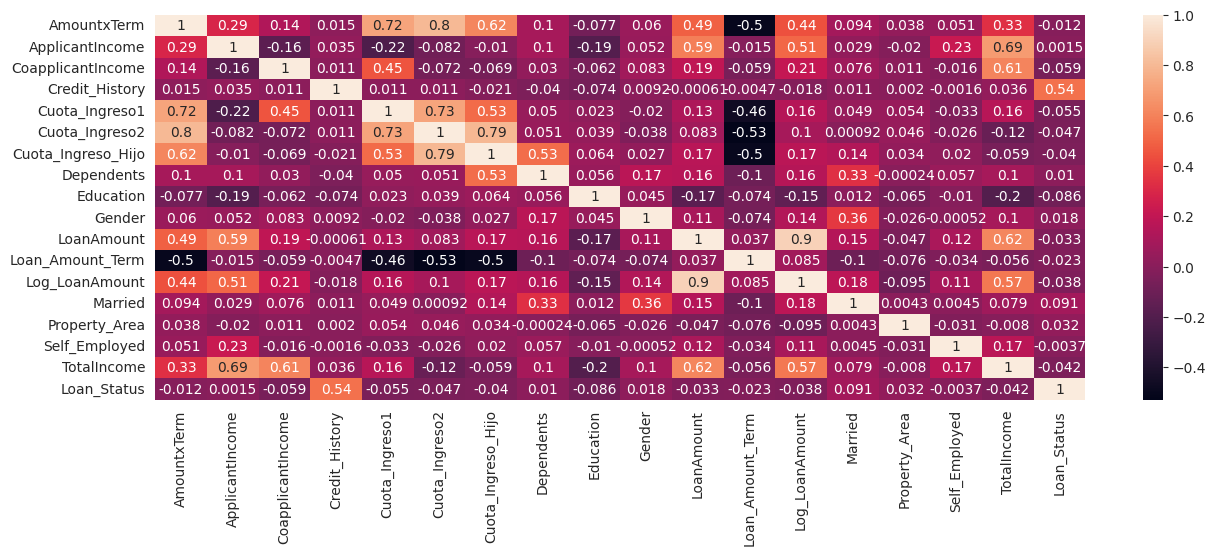

In [102]:
corr = df_modelo.corr()
plt.figure(figsize=(15,5))
sns.heatmap(corr, annot=True);

## Particion Muestral

In [103]:
from sklearn.model_selection import train_test_split

In [104]:
X_train, X_test, y_train, y_test = train_test_split(df_modelo.drop('Loan_Status',axis=1),   #x
                                                    df_modelo.Loan_Status,                  #y
                                                    test_size = 0.33,                 #% datos
                                                    stratify=df_modelo.Loan_Status,
                                                    random_state=100)

In [105]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

print('\nratio del target en y_train :',y_train.value_counts().values/ len(y_train))
print('ratio del target en y_test :',y_test.value_counts().values/ len(y_test))
print('ratio del target en data original :',df_modelo['Loan_Status'].value_counts().values/ len(df_modelo))

X_train shape (411, 17)
y_train shape (411,)
X_test shape (203, 17)
y_test shape (203,)

ratio del target en y_train : [0.68613139 0.31386861]
ratio del target en y_test : [0.68965517 0.31034483]
ratio del target en data original : [0.68729642 0.31270358]


## Regresion Logistica

In [106]:
from sklearn.linear_model import LogisticRegression

In [107]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

#### Analisis

In [108]:
! pip install yellowbrick

In [109]:
from sklearn import metrics as metrics
from yellowbrick.features import FeatureImportances

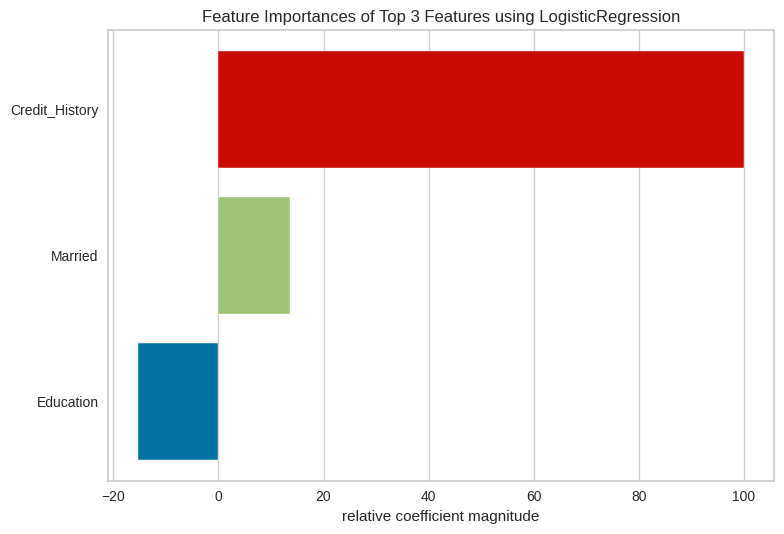

<Axes: title={'center': 'Feature Importances of Top 3 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [110]:
viz = FeatureImportances(lr, relative=True,topn=3)
viz.fit(X_train, y_train)
viz.poof()

#### Seleccion

In [111]:
from yellowbrick.features import RFECV
from sklearn.model_selection import StratifiedKFold

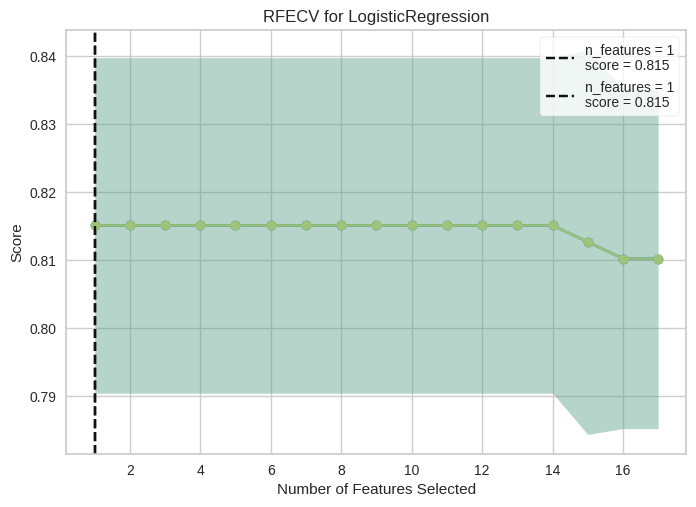

In [112]:
# Selección de variables en la Regresión Logística! (con yellowbrick)
# La primera seleccion de variables es para reducir la dimension del set de datos
# La segunda seleccion de variables es para estabilizar el modelo

cv = StratifiedKFold(5)
visualizer = RFECV(lr, cv=cv, scoring='accuracy')
visualizer.fit(X_train, y_train)
visualizer.draw()
visualizer.finalize()

In [113]:
# Ranking de las variables!
feature_df = pd.DataFrame(df_modelo.drop('Loan_Status',axis=1).columns.tolist(), columns=['features'])
feature_df['rank']=visualizer.ranking_
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)

In [114]:
# Podemos elegir las mas relevantes!
print ('\n Top %d features:' % visualizer.n_features_)
print (feature_df.head(visualizer.n_features_))


 Top 1 features:
         features  rank
0  Credit_History     1


In [115]:
# Paso N°02: Con el algoritmo entrenado predecimos sobre la data de train y test!

y_pred_train=lr.predict(X_train) # Prediccion sobre el train
y_pred_test= lr.predict(X_test) # Prediccion sobre el test

In [116]:
# Paso N°03: Revisamos las metricas de validacion técnicas adecuadas!

# Matriz de confusion
print("Matriz confusion: Train")
cm_train = metrics.confusion_matrix(y_train,y_pred_train)
print(cm_train)

print("Matriz confusion: Test")
cm_test = metrics.confusion_matrix(y_test,y_pred_test)
print(cm_test)

# Accuracy
print("Accuracy: Train")
accuracy_train=metrics.accuracy_score(y_train,y_pred_train)
print(accuracy_train)

print("Accuracy: Test")
accuracy_test=metrics.accuracy_score(y_test,y_pred_test)
print(accuracy_test)

# Precision o Aporte del Modelo
print("Precision: Train")
precision_train=metrics.precision_score(y_train,y_pred_train)
print(precision_train)

print("Precision: Test")
precision_test=metrics.precision_score(y_test,y_pred_test)
print(precision_test)

# Recall o Sensibilidad
print("Recall: Train")
recall_train=metrics.recall_score(y_train,y_pred_train)
print(recall_train)

print("Recall: Test")
recall_test=metrics.recall_score(y_test,y_pred_test)
print(recall_test)

Matriz confusion: Train
[[ 59  70]
 [  7 275]]
Matriz confusion: Test
[[ 25  38]
 [  2 138]]
Accuracy: Train
0.8126520681265207
Accuracy: Test
0.8029556650246306
Precision: Train
0.7971014492753623
Precision: Test
0.7840909090909091
Recall: Train
0.975177304964539
Recall: Test
0.9857142857142858


Es un modelo que tiene buenos indicadores, no hay mucha diferencia (mayor a 5%)

#### Validacion

In [117]:
from yellowbrick.classifier import ConfusionMatrix

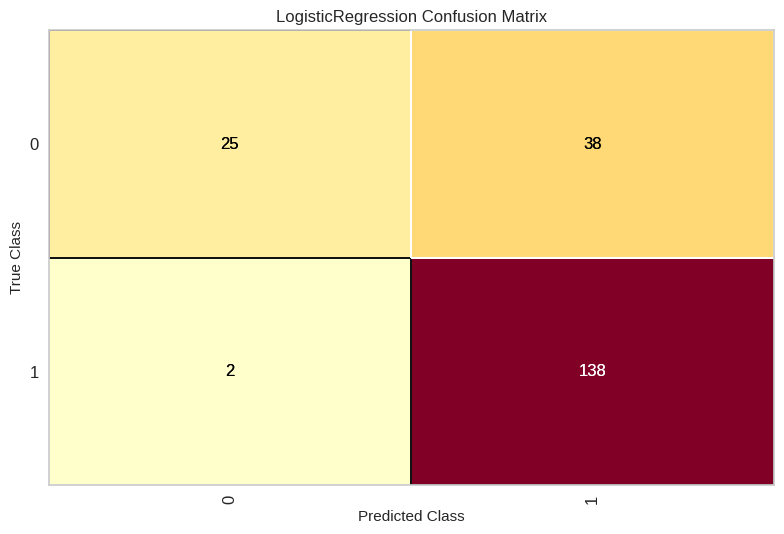

In [118]:
# Matriz de Confusión!
viz = ConfusionMatrix(lr)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.draw()
viz.finalize()

* Globalmente el modelo va bien, para la prediccion de los prestamos tambien va bien, pero para la prediccion de no prestamos (especificidad) no esta yendo bien

In [119]:
from yellowbrick.classifier.rocauc import roc_auc

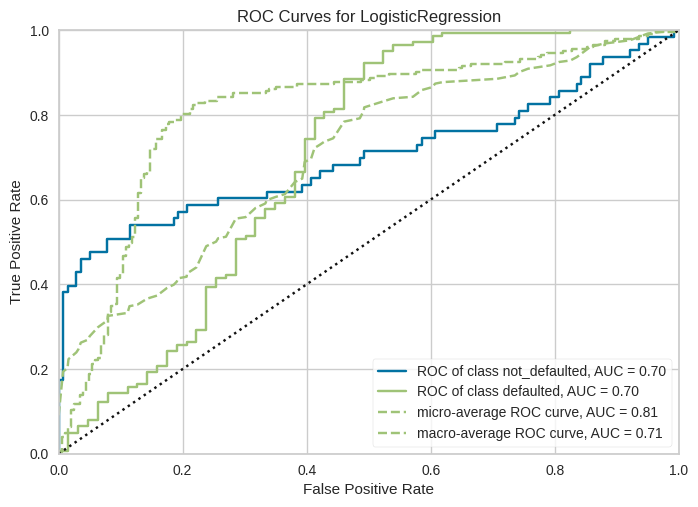

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=['not_defaulted', 'defaulted'], estimator=LogisticRegression())

In [120]:
# Curva ROC- AUC

roc_auc(lr, X_train, y_train, X_test=X_test, y_test=y_test, classes=['not_defaulted', 'defaulted'])

* Curva ROC AOC: en todos los puntos de la probabilidad, que tan bien discriminamos los ceros de los unos. Evalua el poder predictivo.

* El poder predictivo del modelo es 73%.
* El area bajo la curva me ayuda a obtener el GINI (Grado de discriminancia del modelo)
* GINI = 2*auc - 1
* ROC - AUC -> [0% - 100%]

In [121]:
from yellowbrick.classifier import PrecisionRecallCurve

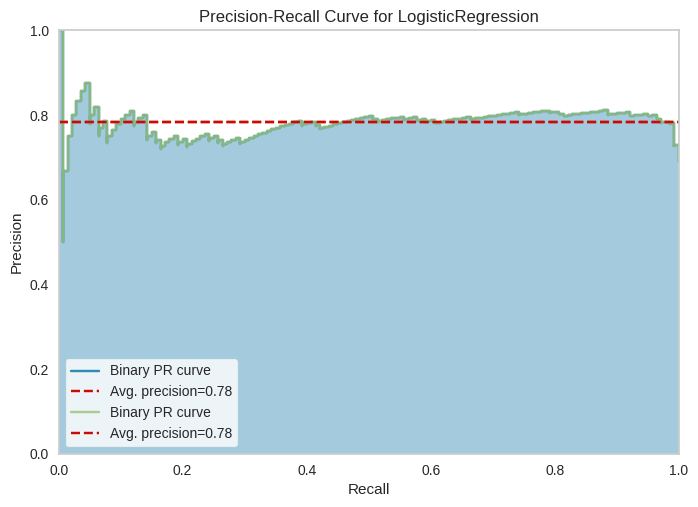

In [122]:
# Curva de Precision vs Recall

viz = PrecisionRecallCurve(lr)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.draw()
viz.finalize()

* Mide que tanto se relaciona la sencibilidad con el aporte del modelo (0.64 es buena metrica)

In [123]:
from yellowbrick.classifier import DiscriminationThreshold

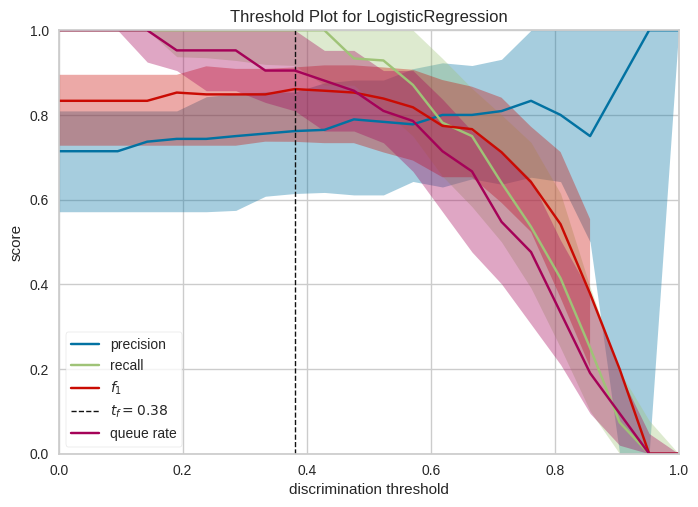

<Axes: title={'center': 'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [124]:
# Todo modelo da probabilidades, cual es el punto de corte optimo?
visualizer = DiscriminationThreshold(lr)
visualizer.fit(X_test, y_test)
visualizer.show()

* Indica donde se intersecta el precision y el recall (entre 0.6 y 0.8),
* entonces para colocar a una persona que acepta el prestamo deberia ser mayor a 0.6

#### Negocio

In [125]:
! pip install scikit-plot

In [126]:
import scikitplot as skplt

In [127]:
# Validacion de Negocio

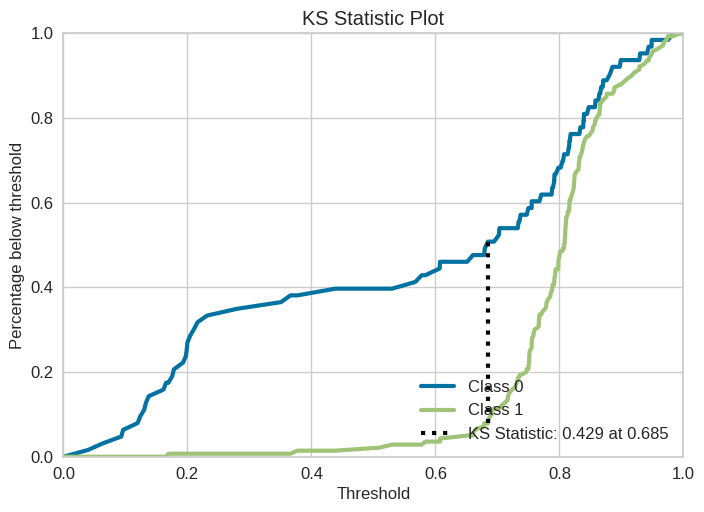

In [128]:
# Indicador de KS ?
# ¿Cuantos leads o clientes necesito gestionar para maximizar las ganancias?

y_probas = lr.predict_proba(X_test)
skplt.metrics.plot_ks_statistic(y_test, y_probas)
plt.draw()

* 0.47 en 57.2% de los datos
* tengo 2M de personas, deberiamos gestionar el 57.2% de la base (los mejores)

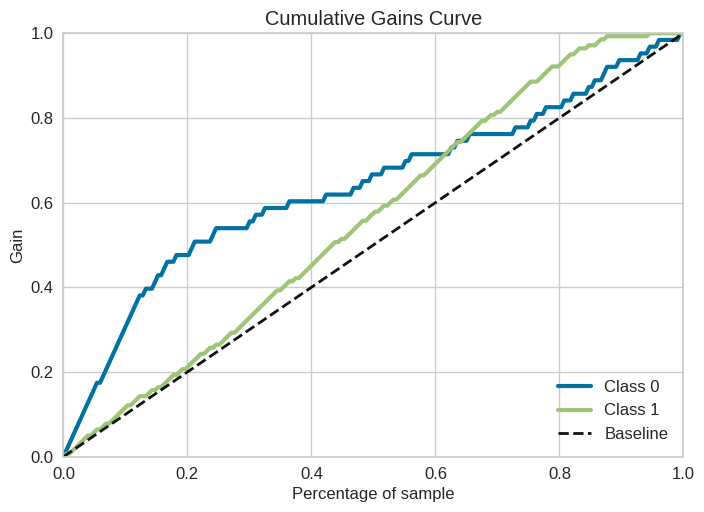

In [129]:
# Curva de Ganancias Acumuladas!

# ¿Cuantos leads o % de base tengo que gestionar para identificar tánto % de préstamos?

y_probas = lr.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
plt.show()

* Si gestiono el 20% de la base, estaria identificando el 21% de los prestamos
* Si gestiono el 40% de la base, estaria identificando el 40% de los prestamos
* Si gestiono el 60% de la base, estaria identificando el 70% de los prestamos

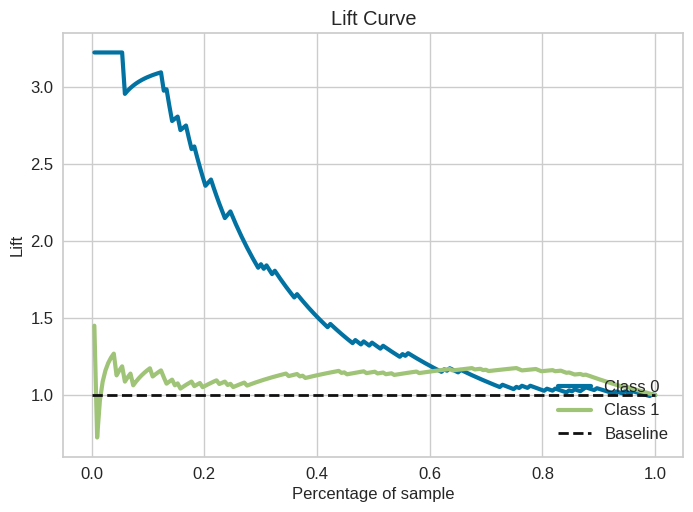

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

In [130]:
# Curva de Lift!
# ¿Que tanto mejor (mas) es?

y_probas = lr.predict_proba(X_test)
skplt.metrics.plot_lift_curve(y_test, y_probas)
plt.show()
plt.title

* aprox en el 40% de la base se obtiene el mejor lift (1.2)
* La efectividad de esa parte de los datos respecto al promedio

**Soluciones:**

* Buscar el punto de corte optimo.
* Hacer una busqueda de los mejores parametros.
* Probar otros algoritmos o modelos de ML.

## Arbol Cart

In [131]:
from sklearn.tree import DecisionTreeClassifier

In [132]:
# Arbol de Clasificacion CART (pequeño)
tree_bonsai = DecisionTreeClassifier(
                       ccp_alpha=0.0,
                       class_weight=None,
                       criterion='gini',
                       max_depth=1,         # Profundidad del arbol
                       max_features=2,     # Numero maximo de variables
                       max_leaf_nodes=None, # Numero de nodos
                       min_samples_leaf=100,
                       min_samples_split=200,
                       min_weight_fraction_leaf=0.0,
                       #presort='deprecated',
                       random_state=None,
                       splitter='best')


# Arbol de Clasificacion CART  (Simple)
tree_complete = DecisionTreeClassifier()


# Arbol de Clasificacion CART (Experto)
tree_expert = DecisionTreeClassifier(
                       ccp_alpha=0.0,
                       class_weight=None,
                       criterion='gini',
                       max_depth=3,         # Profundidad del arbol (4)
                       max_features=6,     # Numero maximo de variables
                       max_leaf_nodes=None, # Numero de nodos
                       min_samples_leaf=20,
                       min_samples_split=40,
                       min_weight_fraction_leaf=0.0,
                       #presort='deprecated',
                       random_state=None,
                       splitter='best')

In [133]:
# Entrenamos los modelos
tree_bonsai = tree_bonsai.fit(X_train,y_train)
tree_complete = tree_complete.fit(X_train,y_train)
tree_expert = tree_expert.fit(X_train,y_train)

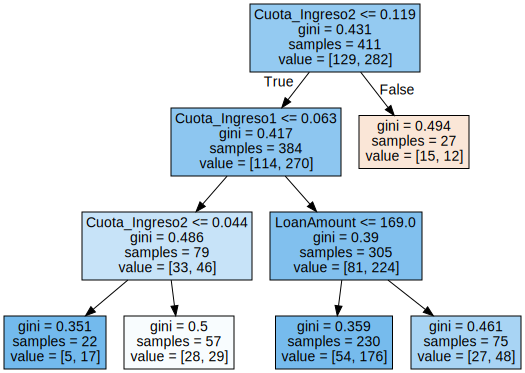

In [134]:
# Visualizando el arbol (experto)
draw_tree(tree_expert, X_train)

In [135]:
# Prediccion
Y_pred_train = tree_expert.predict(X_train)
Y_pred_test  = tree_expert.predict(X_test)

### Metricas

In [136]:
#Cálculo de los indicadores mas relevantes!
from sklearn import metrics as metrics
# Matriz de confusion
print("Matriz confusion: Train")
cm_train = metrics.confusion_matrix(y_train,Y_pred_train)
print(cm_train)

print("Matriz confusion: Test")
cm_test = metrics.confusion_matrix(y_test,Y_pred_test)
print(cm_test)

# Accuracy
print("Accuracy: Train")
accuracy_train=metrics.accuracy_score(y_train,Y_pred_train)
print(accuracy_train)

print("Accuracy: Test")
accuracy_test=metrics.accuracy_score(y_test,Y_pred_test)
print(accuracy_test)

# Precision
print("Precision: Train")
precision_train=metrics.precision_score(y_train,Y_pred_train)
print(precision_train)

print("Precision: Test")
precision_test=metrics.precision_score(y_test,Y_pred_test)
print(precision_test)

# Recall
print("Recall: Train")
recall_train=metrics.recall_score(y_train,Y_pred_train)
print(recall_train)

print("Recall: Test")
recall_test=metrics.recall_score(y_test,Y_pred_test)
print(recall_test)

Matriz confusion: Train
[[ 15 114]
 [ 12 270]]
Matriz confusion: Test
[[  6  57]
 [ 10 130]]
Accuracy: Train
0.6934306569343066
Accuracy: Test
0.6699507389162561
Precision: Train
0.703125
Precision: Test
0.6951871657754011
Recall: Train
0.9574468085106383
Recall: Test
0.9285714285714286


* Con el bonsai obtenemos valores muy bajos (underfitting), mientras que el de pyhon hay overfitting (sobreajuste)

## Random Forest

In [137]:
from sklearn.ensemble import RandomForestClassifier

In [138]:
rf = RandomForestClassifier(n_estimators=500,
                            max_features= 6,
                            max_depth=4
                            ) # Numero de obs por nodo hoja
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=6, n_estimators=500)

In [139]:
# Prediccion
y_pred_train=rf.predict(X_train)
y_pred_test= rf.predict(X_test)

In [140]:
# Comparar el valor pronosticado con el valor real
from sklearn import metrics as metrics
# Matriz de confusion
print("Matriz confusion: Train")
cm_train = metrics.confusion_matrix(y_train,y_pred_train)
print(cm_train)

print("Matriz confusion: Test")
cm_test = metrics.confusion_matrix(y_test,y_pred_test)
print(cm_test)

# Accuracy
print("Accuracy: Train")
accuracy_train=metrics.accuracy_score(y_train,y_pred_train)
print(accuracy_train)

print("Accuracy: Test")
accuracy_test=metrics.accuracy_score(y_test,y_pred_test)
print(accuracy_test)

# Precision
print("Precision: Train")
precision_train=metrics.precision_score(y_train,y_pred_train)
print(precision_train)

print("Precision: Test")
precision_test=metrics.precision_score(y_test,y_pred_test)
print(precision_test)

# Recall
print("Recall: Train")
recall_train=metrics.recall_score(y_train,y_pred_train)
print(recall_train)

print("Recall: Test")
recall_test=metrics.recall_score(y_test,y_pred_test)
print(recall_test)

Matriz confusion: Train
[[ 70  59]
 [  4 278]]
Matriz confusion: Test
[[ 24  39]
 [  2 138]]
Accuracy: Train
0.8467153284671532
Accuracy: Test
0.7980295566502463
Precision: Train
0.8249258160237388
Precision: Test
0.7796610169491526
Recall: Train
0.9858156028368794
Recall: Test
0.9857142857142858


## AdaBoost

In [141]:
from sklearn.ensemble import AdaBoostClassifier

In [142]:
AdaBoost=AdaBoostClassifier(learning_rate=0.001,
                            n_estimators=250)
AdaBoost.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.001, n_estimators=250)

In [143]:
# Prediccion
y_pred_train=AdaBoost.predict(X_train)
y_pred_test= AdaBoost.predict(X_test)

In [144]:
# Comparar el valor pronosticado con el valor real
from sklearn import metrics as metrics
# Matriz de confusion
print("Matriz confusion: Train")
cm_train = metrics.confusion_matrix(y_train,y_pred_train)
print(cm_train)

print("Matriz confusion: Test")
cm_test = metrics.confusion_matrix(y_test,y_pred_test)
print(cm_test)

# Accuracy
print("Accuracy: Train")
accuracy_train=metrics.accuracy_score(y_train,y_pred_train)
print(accuracy_train)

print("Accuracy: Test")
accuracy_test=metrics.accuracy_score(y_test,y_pred_test)
print(accuracy_test)

# Precision
print("Precision: Train")
precision_train=metrics.precision_score(y_train,y_pred_train)
print(precision_train)

print("Precision: Test")
precision_test=metrics.precision_score(y_test,y_pred_test)
print(precision_test)

# Recall
print("Recall: Train")
recall_train=metrics.recall_score(y_train,y_pred_train)
print(recall_train)

print("Recall: Test")
recall_test=metrics.recall_score(y_test,y_pred_test)
print(recall_test)

Matriz confusion: Train
[[ 59  70]
 [  6 276]]
Matriz confusion: Test
[[ 23  40]
 [  1 139]]
Accuracy: Train
0.8150851581508516
Accuracy: Test
0.7980295566502463
Precision: Train
0.7976878612716763
Precision: Test
0.776536312849162
Recall: Train
0.9787234042553191
Recall: Test
0.9928571428571429


## XGBoost

In [145]:
! pip install xgboost

In [146]:
import xgboost as xgb

In [147]:
# Configuramos los datasets
dtrain =  xgb.DMatrix(data=X_train, label = y_train)
dtest   = xgb.DMatrix(data=X_test,   label = y_test)

In [148]:
# Configurar parametros
xgb_params = {
    "objective": "reg:logistic", # Objetivo del negocio!
    "eta": 0.0001,
    "max_depth": 3,
    "early_stopping_rounds":  50,
    "gamma": 0.1,
    "eval_metric": "auc",        # Objetivo del negocio!
    "print_every_n": 50
}
num_rounds = 250

In [149]:
# Ejecutamos
watch_list  = [(dtrain,'train'),(dtest,'test')] # Hacen un listado de los datos
xgb_fit = xgb.train(xgb_params, dtrain, num_rounds, watch_list) # Entrenamiento del algoritmo

[0]	train-auc:0.79213	test-auc:0.72647
[1]	train-auc:0.79232	test-auc:0.72596
[2]	train-auc:0.79232	test-auc:0.72608
[3]	train-auc:0.79232	test-auc:0.72596
[4]	train-auc:0.79232	test-auc:0.72608
[5]	train-auc:0.79232	test-auc:0.72596
[6]	train-auc:0.79232	test-auc:0.72608
[7]	train-auc:0.79232	test-auc:0.72596
[8]	train-auc:0.79232	test-auc:0.72608
[9]	train-auc:0.79232	test-auc:0.72596
[10]	train-auc:0.79232	test-auc:0.72608
[11]	train-auc:0.79232	test-auc:0.72596
[12]	train-auc:0.79232	test-auc:0.72608
[13]	train-auc:0.79232	test-auc:0.72596
[14]	train-auc:0.79232	test-auc:0.72608
[15]	train-auc:0.79232	test-auc:0.72596
[16]	train-auc:0.79232	test-auc:0.72608
[17]	train-auc:0.79232	test-auc:0.72596
[18]	train-auc:0.79232	test-auc:0.72608
[19]	train-auc:0.79232	test-auc:0.72608
[20]	train-auc:0.79232	test-auc:0.72585
[21]	train-auc:0.79232	test-auc:0.72608
[22]	train-auc:0.79232	test-auc:0.72585
[23]	train-auc:0.79232	test-auc:0.72596
[24]	train-auc:0.79232	test-auc:0.72608
[25]	train

In [150]:
# Importancia de Variables
frame = { 'Gain':        pd.Series(xgb_fit.get_score(importance_type='gain')), # Ganancia en prediccion por la variable
          'Cover':       pd.Series(xgb_fit.get_score(importance_type='cover')),# Profundidad del arbol
          'Weight':      pd.Series(xgb_fit.get_score(importance_type='weight'))} # En cuanto arboles sale la variable

result = pd.DataFrame(frame)
result

,Gain,Cover,Weight
AmountxTerm,2.407469,4.816222,125.0
Credit_History,114.099617,89.700226,250.0
Cuota_Ingreso1,4.677355,70.540596,250.0
Cuota_Ingreso2,8.707552,75.356865,250.0
Cuota_Ingreso_Hijo,2.407476,4.816221,125.0


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

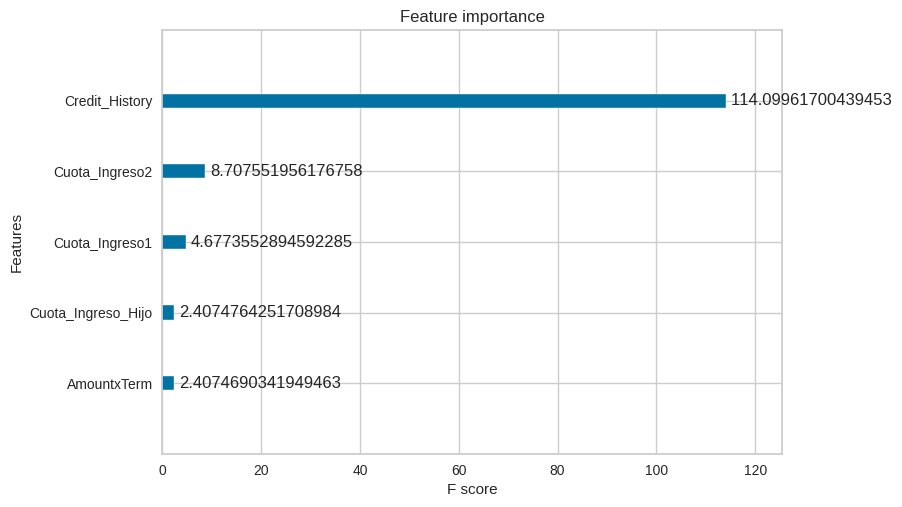

In [151]:
# Importancia de Variables
xgb.plot_importance(xgb_fit,importance_type='gain')

## LightGBM

In [152]:
! pip install lightgbm

In [153]:
import lightgbm as lgb

In [154]:
dtrain = lgb.Dataset(X_train, label=y_train)
dtest =  lgb.Dataset(X_test,  label=y_test, reference=dtrain)

In [155]:
# Configurar parametros
params = {
        'task':'train',
        'is_unbalance': False,
        'max_dept':2,
        'max_bin': 10,  # max cantidad de cortes de una var. numerica
        'boosting_type': 'gbdt',
        'objective': 'binary',   #Objetivo
        #'min_child_weight': 150,
        'metric': 'auc',         #Metrica
        #'min_data_in_leaf': 250,
        'num_leaves': 4,
        'learning_rate': 0.0001,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 10,
        #'min_data_per_group':150 ,
        'early_stopping_rounds':100,
        'verbose': 0,
        'seed ':1234
}

In [156]:
# Ejecutamos
gbm = lgb.train(params,
                dtrain,
                num_boost_round=10000,
                valid_sets=[dtrain,dtest]
                )

[LightGBM] [Warning] Unknown parameter: 1234
[LightGBM] [Warning] Unknown parameter: max_dept
[LightGBM] [Warning] Unknown parameter: 1234
[LightGBM] [Warning] Unknown parameter: max_dept
[LightGBM] [Warning] Unknown parameter: 1234
[LightGBM] [Warning] Unknown parameter: max_dept


In [157]:
# Se debe encontrar una parametrizacion que reduzca la diferencia a 5%

In [158]:
# Importancia de Variables
importancia=gbm.feature_importance(importance_type='gain')

def impxgb(valores,variables):
    dictimp={variables[a]:valores[a] for a in range(0,len(variables)) }
    xgimp=sorted(list(dictimp.items()), key=lambda x: x[1],reverse=True)

    return xgimp

ixg=impxgb(importancia,X_train.columns)
pd.Series(ixg)

0         (Credit_History, 8480.484550476074)
1          (Property_Area, 326.9383010864258)
2        (Cuota_Ingreso1, 238.84431076049805)
3        (Cuota_Ingreso2, 217.14424085617065)
4        (ApplicantIncome, 125.4688708782196)
5      (CoapplicantIncome, 51.90051007270813)
6             (Education, 39.560659885406494)
7                (Married, 33.64577007293701)
8            (LoanAmount, 29.474610090255737)
9     (Cuota_Ingreso_Hijo, 19.41774010658264)
10          (TotalIncome, 14.803489685058594)
11           (AmountxTerm, 6.143509864807129)
12          (Log_LoanAmount, 5.3056800365448)
13                          (Dependents, 0.0)
14                              (Gender, 0.0)
15                    (Loan_Amount_Term, 0.0)
16                       (Self_Employed, 0.0)
dtype: object

## CatBoost

In [159]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.9 MB/s eta 0:00:00


In [160]:
from catboost import CatBoostClassifier

In [161]:
CatBoost=CatBoostClassifier(eval_metric="AUC",
                            one_hot_max_size=20,
                            depth=2,
                            iterations= 800,
                            l2_leaf_reg= 2,
                            learning_rate= 0.0001)

Cat=CatBoost.fit(X_train,y_train)

0:	total: 47.2ms	remaining: 37.7s
1:	total: 47.9ms	remaining: 19.1s
2:	total: 48.6ms	remaining: 12.9s
3:	total: 50.5ms	remaining: 10.1s
4:	total: 51.3ms	remaining: 8.16s
5:	total: 52.1ms	remaining: 6.89s
6:	total: 53.1ms	remaining: 6.02s
7:	total: 54ms	remaining: 5.35s
8:	total: 54.8ms	remaining: 4.81s
9:	total: 55.5ms	remaining: 4.39s
10:	total: 56.3ms	remaining: 4.04s
11:	total: 57.2ms	remaining: 3.76s
12:	total: 58ms	remaining: 3.51s
13:	total: 58.8ms	remaining: 3.3s
14:	total: 59.6ms	remaining: 3.12s
15:	total: 60.4ms	remaining: 2.96s
16:	total: 61.2ms	remaining: 2.82s
17:	total: 61.9ms	remaining: 2.69s
18:	total: 62.6ms	remaining: 2.57s
19:	total: 63.4ms	remaining: 2.47s
20:	total: 64.2ms	remaining: 2.38s
21:	total: 64.9ms	remaining: 2.29s
22:	total: 65.6ms	remaining: 2.21s
23:	total: 66.3ms	remaining: 2.14s
24:	total: 67.4ms	remaining: 2.09s
25:	total: 75.3ms	remaining: 2.24s
26:	total: 76.1ms	remaining: 2.18s
27:	total: 76.8ms	remaining: 2.12s
28:	total: 77.6ms	remaining: 2.06s


In [162]:
# Prediccion
y_pred_train=Cat.predict(X_train)
y_pred_test=Cat.predict(X_test)

In [163]:
# Comparar el valor pronosticado con el valor real
from sklearn import metrics as metrics
# Matriz de confusion
print("Matriz confusion: Train")
cm_train = metrics.confusion_matrix(y_train,y_pred_train)
print(cm_train)

print("Matriz confusion: Test")
cm_test = metrics.confusion_matrix(y_test,y_pred_test)
print(cm_test)

# Accuracy
print("Accuracy: Train")
accuracy_train=metrics.accuracy_score(y_train,y_pred_train)
print(accuracy_train)

print("Accuracy: Test")
accuracy_test=metrics.accuracy_score(y_test,y_pred_test)
print(accuracy_test)

# Precision
print("Precision: Train")
precision_train=metrics.precision_score(y_train,y_pred_train)
print(precision_train)

print("Precision: Test")
precision_test=metrics.precision_score(y_test,y_pred_test)
print(precision_test)

# Recall
print("Recall: Train")
recall_train=metrics.recall_score(y_train,y_pred_train)
print(recall_train)

print("Recall: Test")
recall_test=metrics.recall_score(y_test,y_pred_test)
print(recall_test)

Matriz confusion: Train
[[ 59  70]
 [  6 276]]
Matriz confusion: Test
[[ 23  40]
 [  1 139]]
Accuracy: Train
0.8150851581508516
Accuracy: Test
0.7980295566502463
Precision: Train
0.7976878612716763
Precision: Test
0.776536312849162
Recall: Train
0.9787234042553191
Recall: Test
0.9928571428571429


# Otra Forma

In [164]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=1, random_state=42)
}

In [165]:
# loss

from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, accuracy_score

def loss(y_true, y_pred, retu=False):
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    loss = log_loss(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    if retu:
        return pre, rec, f1, loss, acc
    else:
        print('  pre: %.3f\n  rec: %.3f\n  f1: %.3f\n  loss: %.3f\n  acc: %.3f' % (pre, rec, f1, loss, acc))

In [166]:
# train_eval_train

def train_eval_train(models, X, y):
    for name, model in models.items():
        print(name,':')
        model.fit(X, y)
        loss(y, model.predict(X))
        print('-'*30)

train_eval_train(models, X_train, y_train)

# we can see that best model is LogisticRegression at least for now, SVC is just memorizing the data so it is overfitting .

LogisticRegression :
  pre: 0.797
  rec: 0.975
  f1: 0.877
  loss: 6.753
  acc: 0.813
------------------------------
KNeighborsClassifier :
  pre: 0.762
  rec: 0.922
  f1: 0.835
  loss: 9.033
  acc: 0.749
------------------------------
SVC :
  pre: 0.688
  rec: 1.000
  f1: 0.815
  loss: 11.225
  acc: 0.689
------------------------------
DecisionTreeClassifier :
  pre: 0.798
  rec: 0.979
  f1: 0.879
  loss: 6.665
  acc: 0.815
------------------------------


In [167]:
# train_eval_cross
# in the next cell i will be explaining this function

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

def train_eval_cross(models, X, y, folds):
    # we will change X & y to dataframe because we will use iloc (iloc don't work on numpy array)
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    idx = [' pre', ' rec', ' f1', ' loss', ' acc']
    for name, model in models.items():
        ls = []
        print(name,':')

        for train, test in folds.split(X, y):
            model.fit(X.iloc[train], y.iloc[train])
            y_pred = model.predict(X.iloc[test])
            ls.append(loss(y.iloc[test], y_pred, retu=True))
        print(pd.DataFrame(np.array(ls).mean(axis=0), index=idx)[0])  #[0] because we don't want to show the name of the column
        print('-'*30)

train_eval_cross(models, X_train, y_train, skf)

# ohhh, as i said SVC is just memorizing the data, and you can see that here DecisionTreeClassifier is better than LogisticRegression

LogisticRegression :
 pre     0.798768
 rec     0.975246
 f1      0.877495
 loss    6.756615
 acc     0.812544
Name: 0, dtype: float64
------------------------------
KNeighborsClassifier :
 pre      0.695188
 rec      0.809113
 f1       0.746191
 loss    13.494392
 acc      0.625610
Name: 0, dtype: float64
------------------------------
SVC :
 pre      0.684573
 rec      0.992980
 f1       0.810385
 loss    11.487083
 acc      0.681301
Name: 0, dtype: float64
------------------------------
DecisionTreeClassifier :
 pre     0.799373
 rec     0.978818
 f1      0.879416
 loss    6.668704
 acc     0.814983
Name: 0, dtype: float64
------------------------------


In [168]:
# some explanation of the above function

x = []
idx = [' pre', ' rec', ' f1', ' loss', ' acc']

# we will use one model
log = LogisticRegression()

for train, test in skf.split(X_train, y_train):
    log.fit(X_train.iloc[train], y_train.iloc[train])
    ls = loss(y_train.iloc[test], log.predict(X_train.iloc[test]), retu=True)
    x.append(ls)

# thats what we get
pd.DataFrame(x, columns=idx)

# (column 0 represent the precision_score of the 10 folds)
# (row 0 represent the (pre, rec, f1, loss, acc) for the first fold)
# then we should find the mean of every column
# pd.DataFrame(x, columns=idx).mean(axis=0)

,pre,rec,f1,loss,acc
0,0.828571,1.000000,0.906250,5.149093,0.857143
1,0.848485,1.000000,0.918033,4.395567,0.878049
2,0.771429,0.964286,0.857143,7.912021,0.780488
3,0.777778,1.000000,0.875000,7.032908,0.804878
4,0.806452,0.892857,0.847458,7.912021,0.780488
5,0.800000,1.000000,0.888889,6.153794,0.829268
6,0.848485,1.000000,0.918033,4.395567,0.878049
7,0.710526,0.964286,0.818182,10.549362,0.707317
8,0.777778,1.000000,0.875000,7.032908,0.804878
9,0.818182,0.931034,0.870968,7.032908,0.804878


# **V. Grid Search de Paramatros**

In [169]:
from sklearn.model_selection import GridSearchCV         # Busqueda exhaustiva de la mejor combinacion
from sklearn.model_selection import RandomizedSearchCV   # Busqueda aleatoria de la mejor combinacion
from scipy.stats import randint as sp_randint

In [170]:
# Configuramos el subset de parametros a trabajar
cv_params = {'max_depth': [2,3,5,7,9],
            'subsample':[0.4,0.5,0.6,0.7],
             'n_estimators':[100,300,500,800,1000]}

In [171]:
# Definimos un clasificador inicial, generalmente sin muchos parametros
xgboost_t=xgb.XGBClassifier().fit(X_train, y_train)

In [172]:
# Con el clasificador inicial, tratamos de buscar los mejores parametros
optimized_GBM = GridSearchCV(xgboost_t, cv_params, scoring = 'accuracy', cv = 5)

In [173]:
%%time
# Buscamos los parametros de acuerdo a nuestro criterio
optimized_GBM.fit(X_train, y_train)

CPU times: user 4min 16s, sys: 3.7 s, total: 4min 20s
Wall time: 2min 56s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [2, 3, 5, 7, 9],
                         'n_estimators': [100, 300, 500, 800, 1000],
                         'subsample': [0.4, 0.5, 0.6, 0.7]},
             scoring='accuracy')

In [174]:
# De acuerdo a la busqueda , nos quedamos con los mejores parametros
print (optimized_GBM.best_params_)

{'max_depth': 2, 'n_estimators': 100, 'subsample': 0.6}


In [175]:
# Con el clasificador inicial, tratamos de buscar los mejores parametros
optimized_GBM2 = RandomizedSearchCV(xgboost_t, cv_params, scoring = 'accuracy', cv = 5)

In [176]:
# Buscamos los parametros de acuerdo a nuestro criterio
optimized_GBM2.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'max_depth': [2, 3, 5, 7, 9],
                                        'n_estimators': [100, 300, 500, 800,
                                                         1000],
                                        'subsample': [0.4, 0.5, 0.6, 0.7]},
                   scoring='accuracy')

In [177]:
# De acuerdo a la busqueda , nos quedamos con los mejores parametros
print (optimized_GBM2.best_params_)

{'subsample': 0.6, 'n_estimators': 500, 'max_depth': 2}


# **VI. Explicabilidad e Interpretacion**

In [178]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 8.2 MB/s eta 0:00:00


In [179]:
import shap
shap.initjs()

In [180]:
shap.initjs()
# Usamos el algoritmo que tengamos entrenado y creamos los valores SHAP
explainer = shap.TreeExplainer(xgb_fit)   # Decodifica el algoritmo. ==> Explicabilidad del arbol
shap_values = explainer.shap_values(X_train)

In [181]:
X_train.shape

(411, 17)

In [182]:
shap_values.shape

(411, 17)

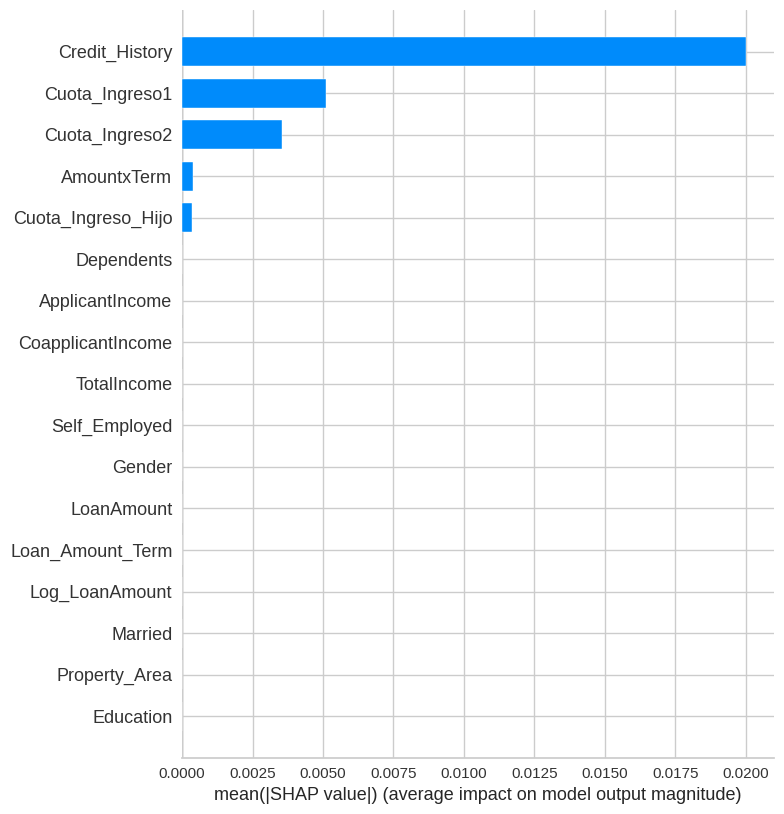

In [183]:
# Vista global de importancia de variables
shap.summary_plot(shap_values, X_train, plot_type="bar")

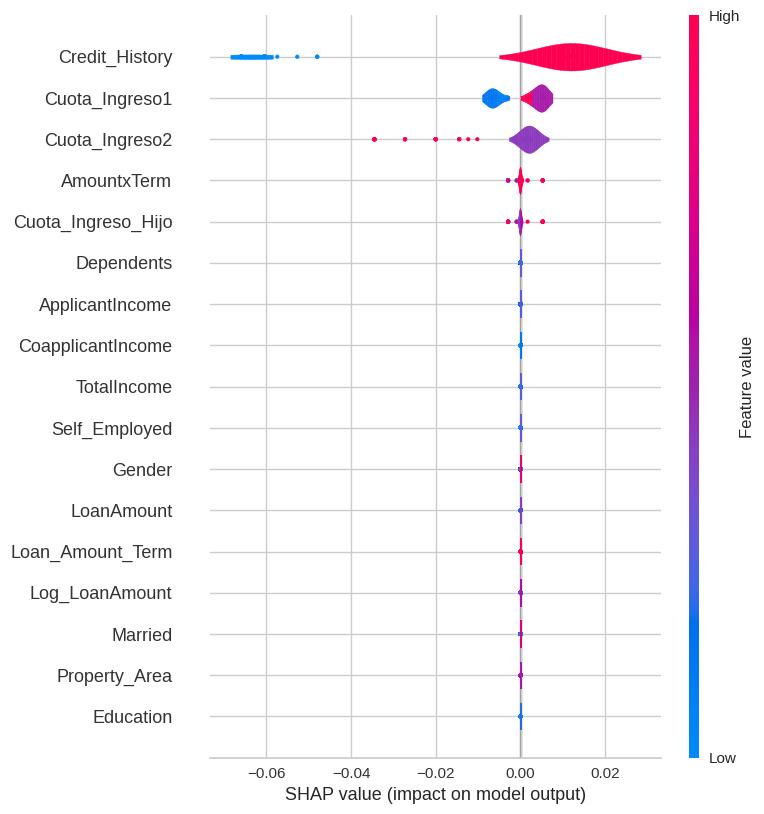

In [184]:
# Vista global de importancia de variables
shap.summary_plot(shap_values, X_train, plot_type="violin")

In [185]:
#  - Probabilidad de Adquirir Prestamo (1)   (izquierda)         ||             + Probabilidad de Adquirir Prestamo (1) (derecha)
# Color Rojo: Mayor (Alto) valor de la variable
# Color Azul: Menor (Bajo) valor de la variable

# Credit_history ==> Rojo (Alto valor de la variable) y a la derecha, es decir, para un alto valor de credit history, aumenta la probabilidad de
#                      adquirir el prestamo

#                               (cuota)
# cuota_ingreso2 ==> (monto del prestamo/tiempo) / (ingreso) ==> Ratio endeudamiento
# Es azul y esta a la derecha: para bajos valores de ratio de endeudamiento, la probabilidad de adquirir el prestamo crece


#TotalIncome ==> Azul y derecha
# Si la persona tiene bajo valor de ingreso, tienen alta probabilidad de aqdquirir el prestamo (es lo que dice los datos)

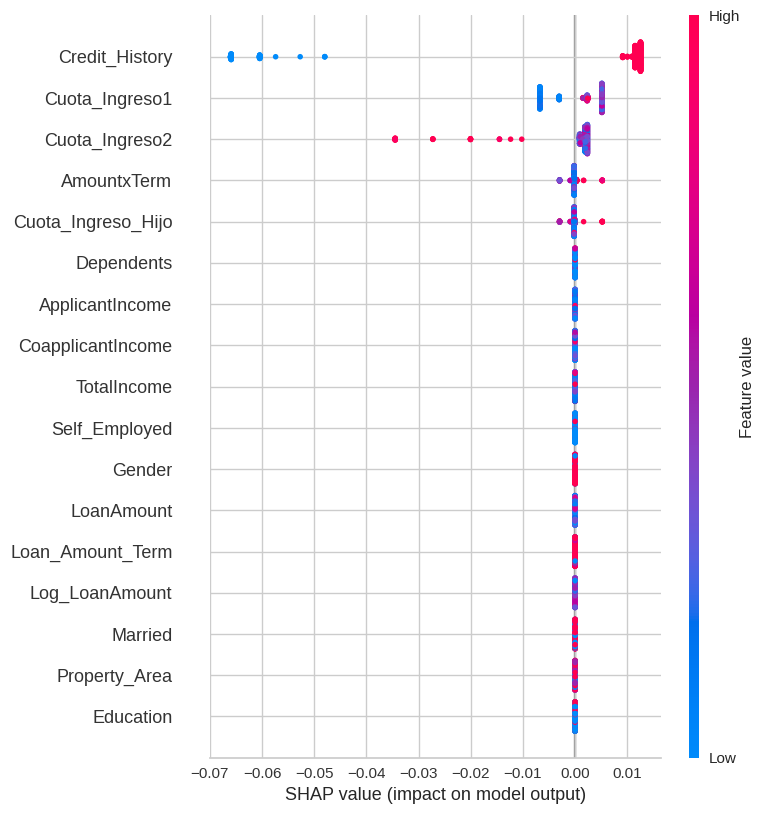

In [186]:
# Podemos resumir los efectos de las caracteristicas sobre el deafault.
shap.initjs()
shap. summary_plot (shap_values , X_train)

In [187]:
# Relacion entre variable y target

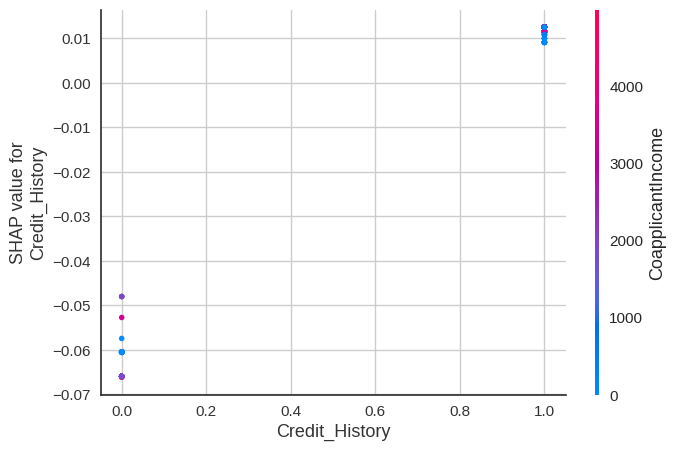

In [188]:
# Podemos ver que variable correlacionada con otra influye en las predicciones
shap.dependence_plot("Credit_History",shap_values, X_train)

In [189]:
# Visualice la explicación de la primera predicción (use matplotlib = True para evitar Javascript) (se puede ver por cada persona)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[20], features=X_train.loc[20], feature_names=X_train.columns)

In [190]:
# Por ejemplo, la persona 50 del set dedatos, tiene alta probabilidad de obtener el prestamo pq tienehistorial crediticio
# ingreso tortal de 3k y cuota de ingreso 0.07

In [191]:
# Visualice la explicación de la primera predicción (use matplotlib = True para evitar Javascript) (se puede ver por cada persona)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[4], features=X_train.loc[4], feature_names=X_train.columns)

In [192]:
# Por ejemplo, la persona 4 del set dedatos, tiene baja probabilidad de obtener el prestamo

## Guardar Modelo

In [193]:
import pickle

In [196]:
path_modelo = ''

In [197]:
# filename = path_modelo + 'RegresionLogistica.sav'
# pickle.dump(rf, open(filename, 'wb'))

In [198]:
# # Leemos el modelo supervisado de algun lugar o espacio de almacenamiento!
# filename = path_modelo + 'RegresionLogistica.sav'
# rf_lectura = pickle.load(open(filename, 'rb'))
# rf_lectura

In [199]:
# rf_lectura.get_params()